In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools
import pingouin as pg
import numpy as np
from pymer4.models import Lm, Lmer

sns.set_theme(
    style = 'white',
    palette = 'Set1',
    rc={"figure.dpi": 150}
)

# Utility functions

In [2]:
def print_ttest(res, text):
    print(f'{text}: t({res.df})={res.statistic:.2f}, p={res.pvalue:.2f}')


def sdt_cat(pair):
    match pair:
        case ('true', 'true'):
            return 'hit'
        case ('true', 'fake'):
            return 'miss'
        case ('fake', 'true'):
            return 'fa'
        case ('fake', 'fake'):
            return 'cr'


def get_stats(data=None, type=None):
    hit = len(data[data['category_new'] == 'hit'])
    miss = len(data[data['category_new'] == 'miss'])
    cr = len(data[data['category_new'] == 'cr'])
    fa = len(data[data['category_new'] == 'fa'])

    if type == 'sdt':
        hit_rate = hit / (hit+miss)
        fa_rate = fa / (fa+cr)
        d_prime = stats.norm.ppf(hit_rate) - stats.norm.ppf(fa_rate)
        res = pd.Series({
                            'Hit Rate':hit_rate, 
                            'False Alarm Rate':fa_rate,
                            'd prime':d_prime
                        })
    elif type == 'accuracy':
        res = (hit+cr)/len(data)
    
    return res

# Load DataFrame

In [3]:
df = pd.concat([pd.read_csv(file) for file in glob.glob('./responses/*/*')], ignore_index=True)

# Remove trials in practice block and drop date column
df = df[df['block'] != 'practice'].drop('date', axis=1).reset_index(drop=True)
# Change some participants' condition column from TRUE (bool) to true (str)
df['condition'] = df.apply(lambda x: 'true' if x['condition']=='TRUE' or x['condition']=='true' else 'fake', axis=1)
# Standardize responses for each participant
df['z_response'] = df.groupby('subject')['response'].transform(lambda x: StandardScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())
# Add column for true/fake response
df['binary_resp'] = df.apply(lambda x: 'true' if x['response'] > 5.5 else 'fake', axis=1)
# Add column for which SDT category (hit/miss/cr/fa)
df['category_new'] = df.apply(lambda x: sdt_cat((x['condition'], x['binary_resp'])), axis=1)

In [4]:
df

,subject,age,sex,trial_num,block_num,block,video_path,audio_path,condition,category,duration,eye_fit,mouth_fit,genuineness,response,z_response,binary_resp,category_new
0,1,22.0,m,1,1,eyes,./stimuli/eyes/52_3.mov,./stimuli/audio/52/3_audio.wav,true,hit,10,0.280581,0.210438,0.750000,8.0,1.086711,true,hit
1,1,22.0,m,2,1,eyes,./stimuli/eyes/58_1_2.mov,./stimuli/audio/58/1_2_audio.wav,fake,fa,14,0.020211,0.104356,0.600000,3.0,-0.799122,fake,cr
2,1,22.0,m,3,1,eyes,./stimuli/eyes/2_2_3.mov,./stimuli/audio/2/2_3_audio.wav,fake,fa,8,-0.050236,0.129175,0.571429,7.0,0.709545,true,fa
3,1,22.0,m,4,1,eyes,./stimuli/eyes/5_1.mov,./stimuli/audio/5/1_audio.wav,true,hit,19,0.331329,0.271282,1.000000,4.0,-0.421955,fake,miss
4,1,22.0,m,5,1,eyes,./stimuli/eyes/14_2.mov,./stimuli/audio/14/2_audio.wav,true,miss,7,-0.168140,0.457204,0.400000,7.0,0.709545,true,hit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9,21.0,f,36,4,original,./stimuli/original/60_4_6.mov,./stimuli/audio/60/4_6_audio.wav,fake,cr,9,0.253970,-0.404008,0.333333,3.0,-0.858096,fake,cr
3356,9,21.0,f,37,4,original,./stimuli/original/45_3.mov,./stimuli/audio/45/3_audio.wav,true,miss,7,0.038899,0.168890,0.125000,6.0,0.090950,true,hit
3357,9,21.0,f,38,4,original,./stimuli/original/22_19_3_23_2.mov,./stimuli/audio/22/19_3_23_2_audio.wav,fake,fa,11,-0.043332,0.084844,0.600000,10.0,1.356346,true,fa
3358,9,21.0,f,39,4,original,./stimuli/original/56_2_3.mov,./stimuli/audio/56/2_3_audio.wav,fake,fa,11,-0.066640,0.508794,0.750000,8.0,0.723648,true,fa


# Demographics

In [5]:
grouped = df.groupby('subject')

N = df['subject'].nunique()
age = grouped['age'].apply(lambda x: x.iloc[0])
sex = grouped['sex'].apply(lambda x: x.iloc[0]).value_counts()

print(f'N={N} (Male={sex["m"]}, Female={sex["f"]})')
print('Age: M={:.2f}, SD={:.2f}'.format(age.mean(), age.std()))

N=21 (Male=15, Female=6)
Age: M=21.14, SD=0.96


# Responses

## Per participant

G:\Utilisateurs\rudradeep.guha\AppData\Local\Temp\ipykernel_4240\3071132253.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2, figsize=(10, 4))


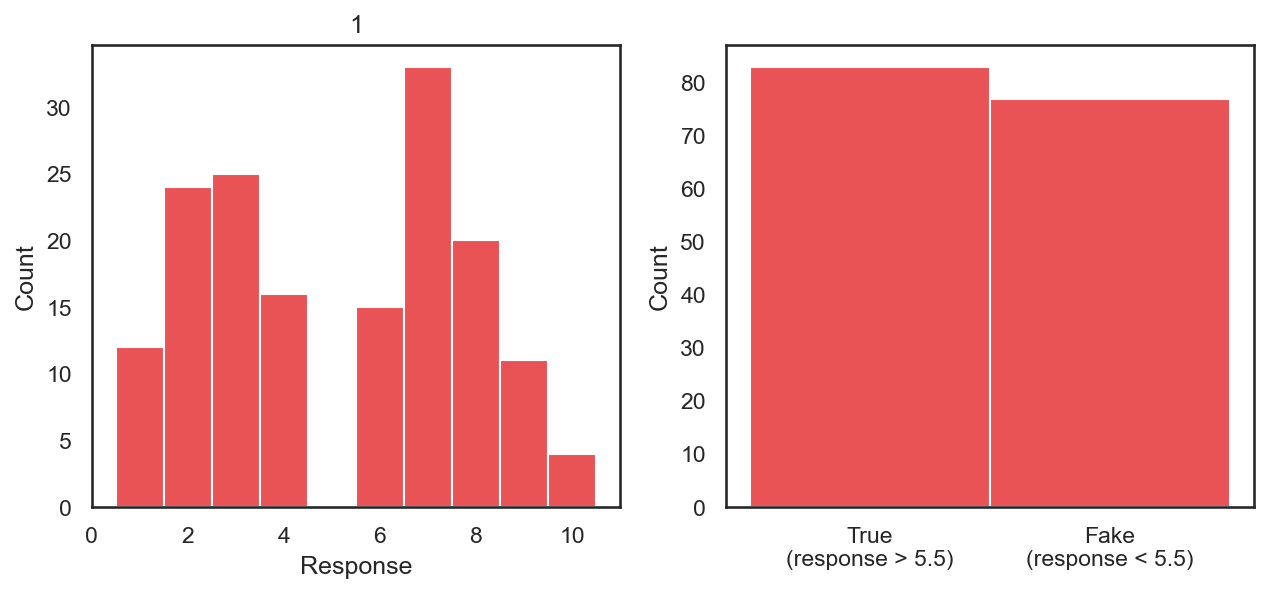

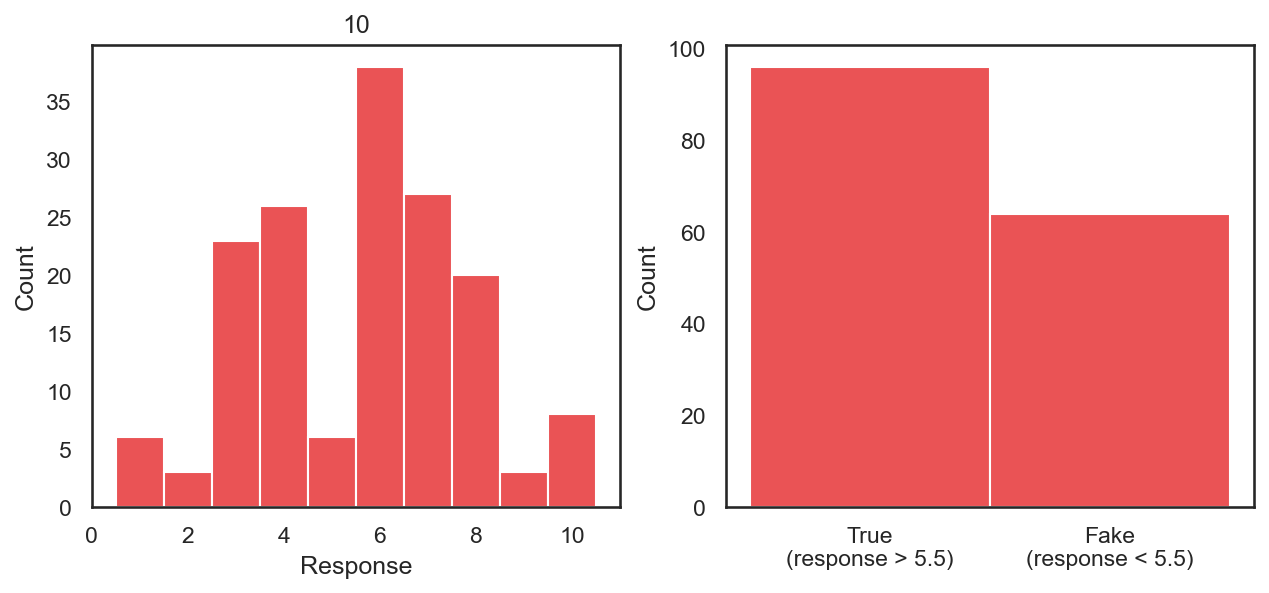

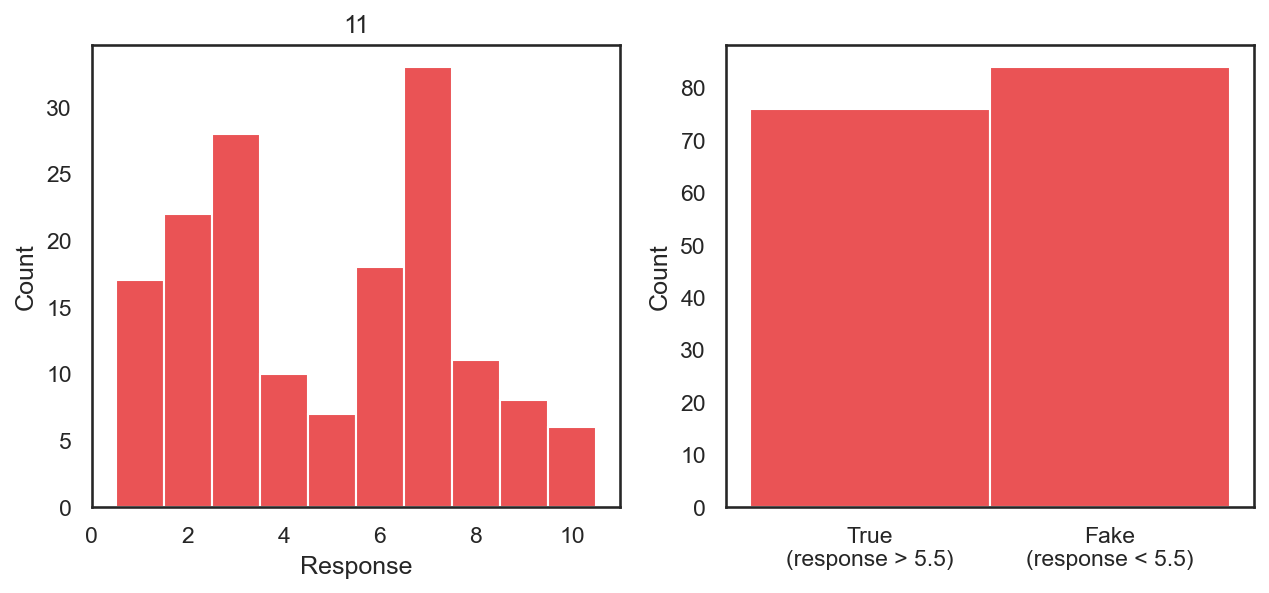

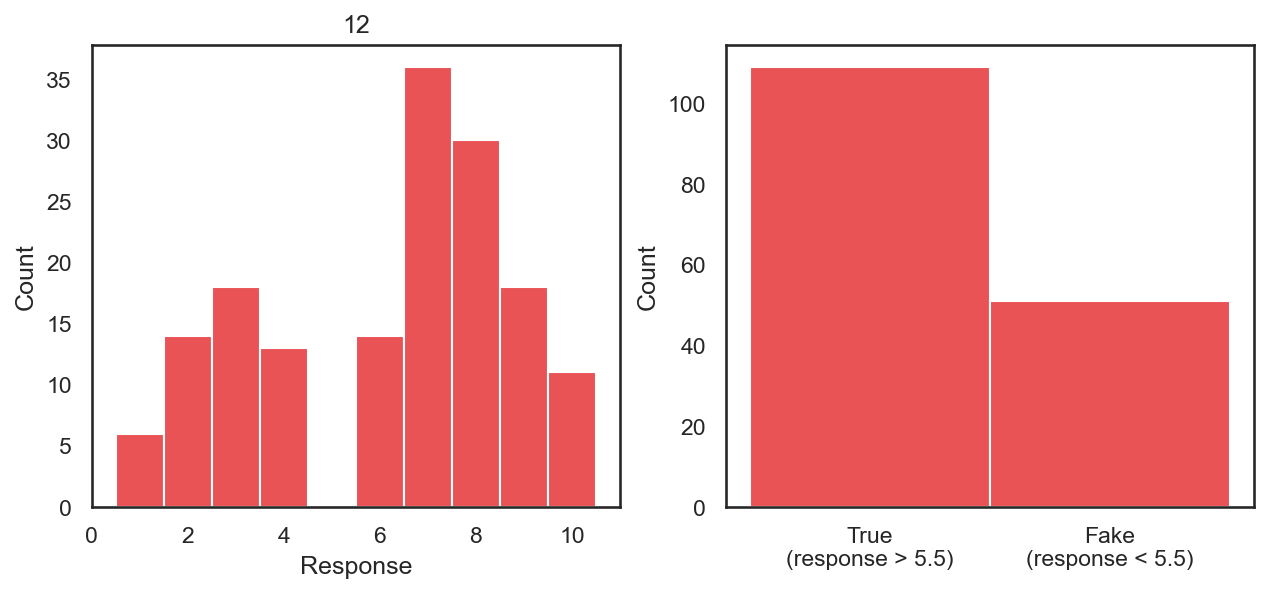

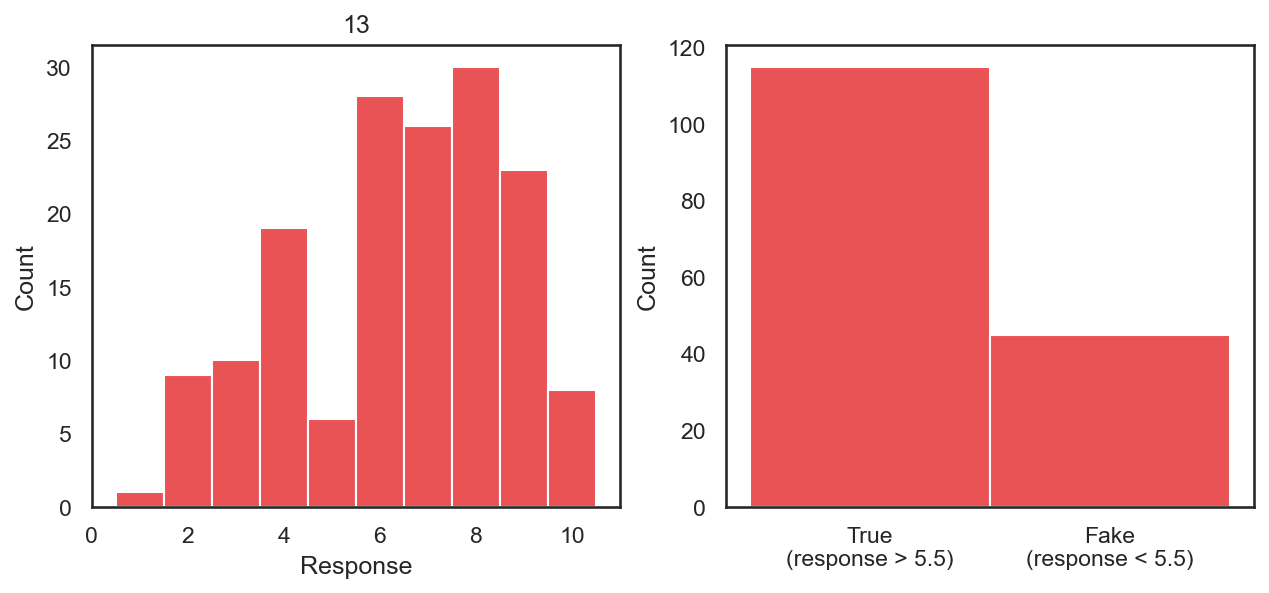

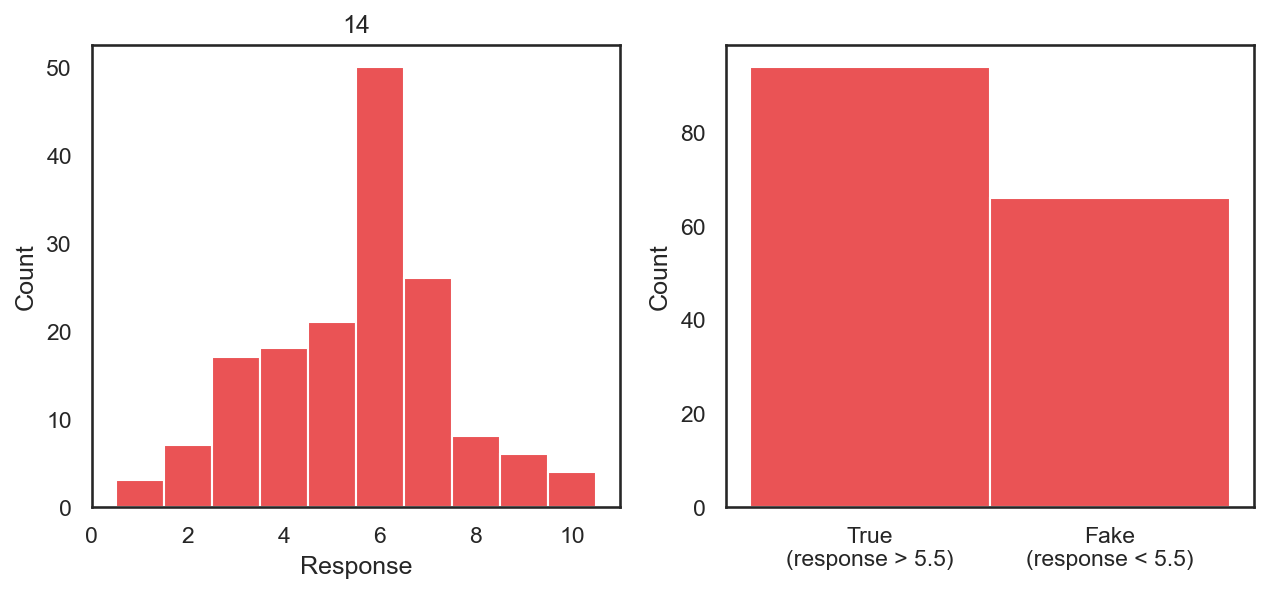

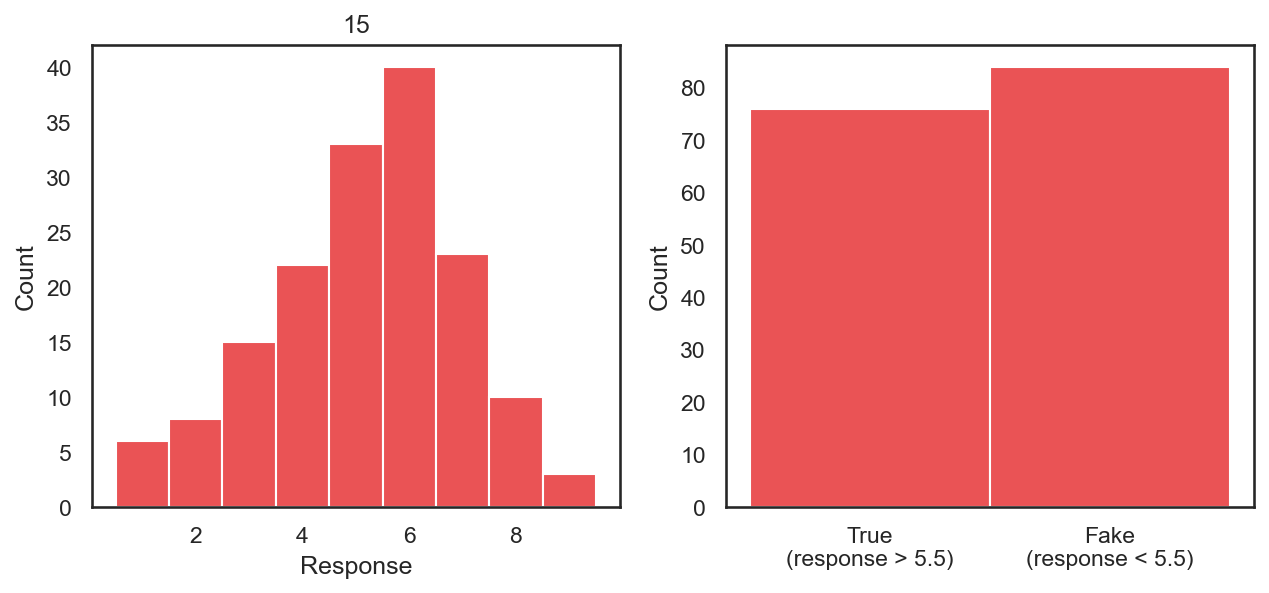

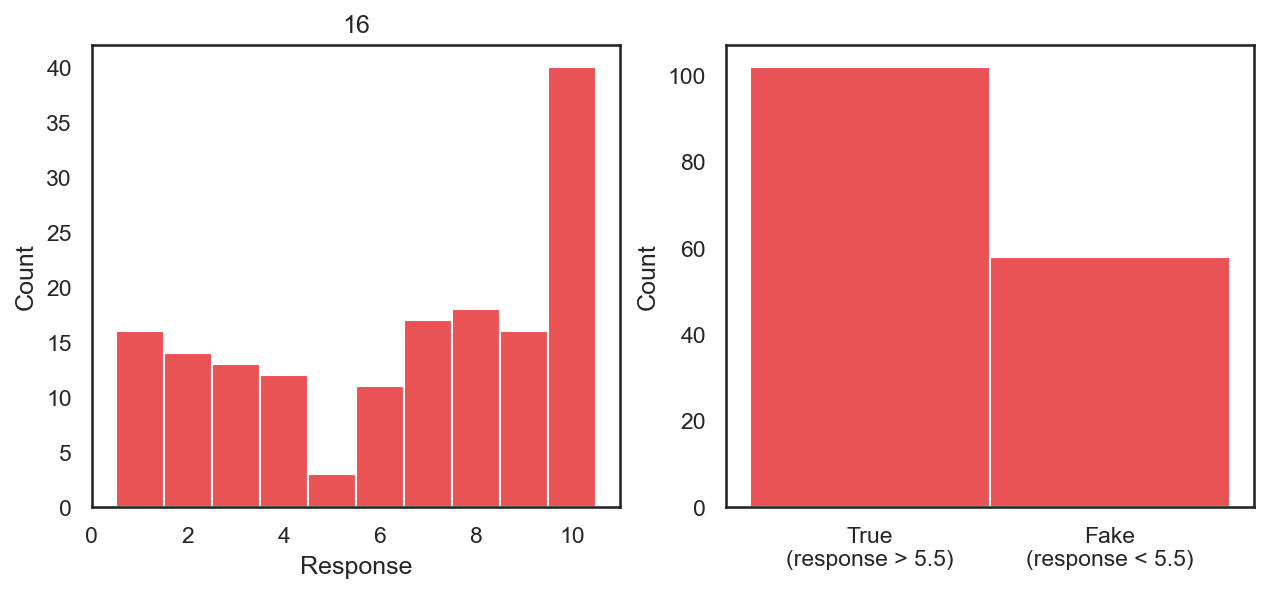

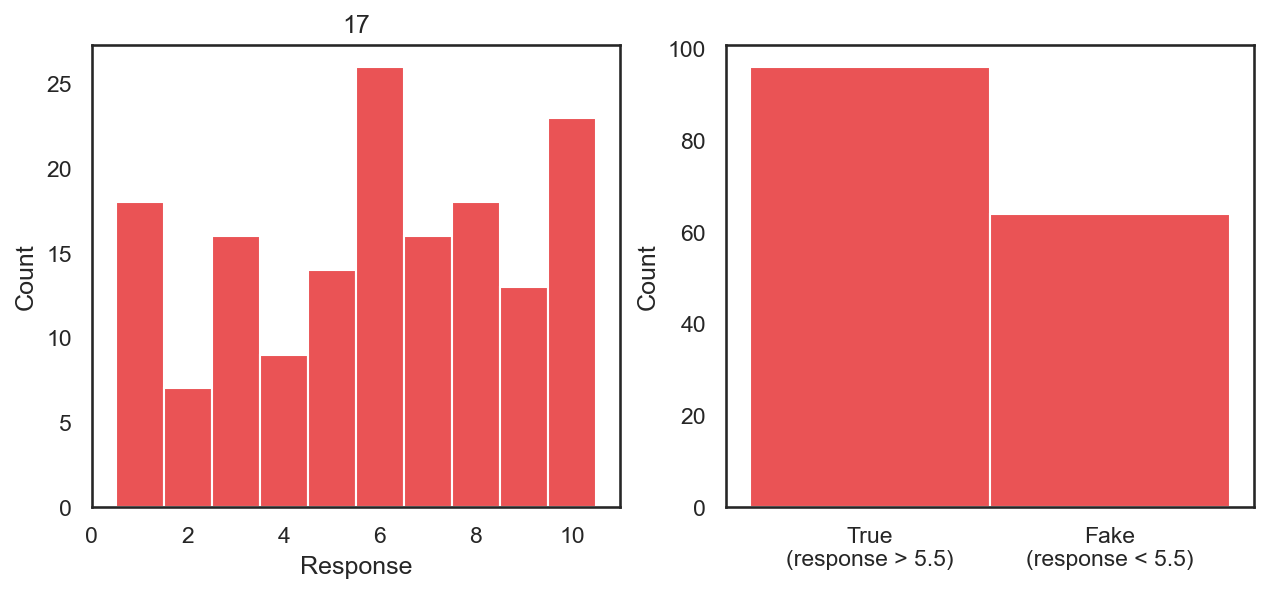

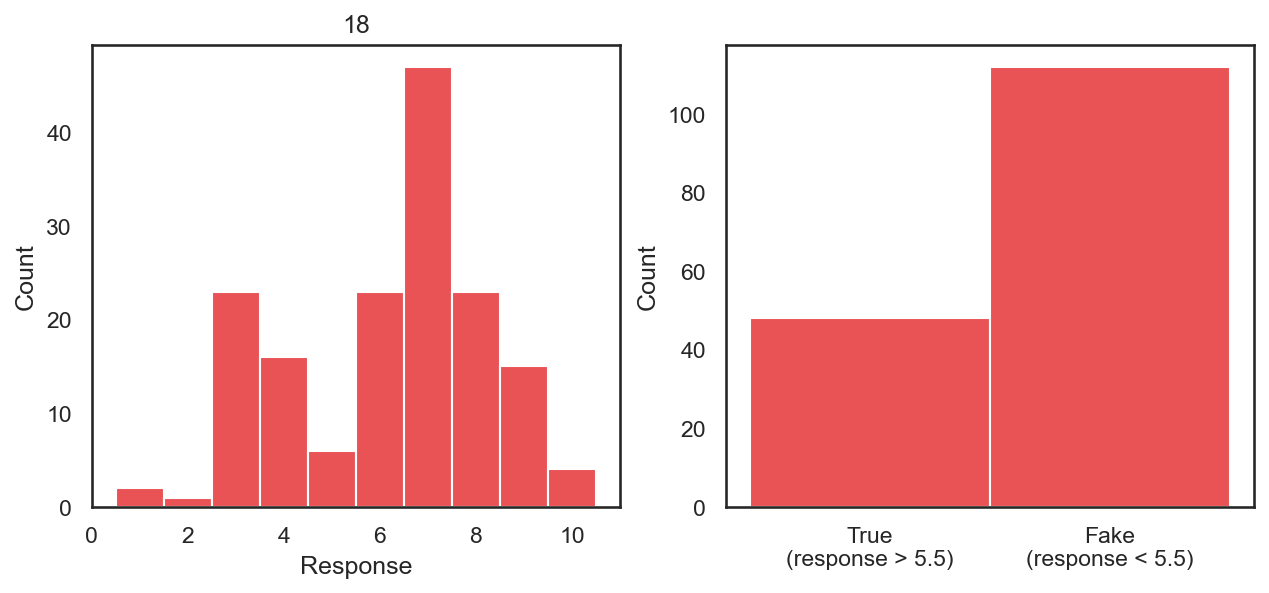

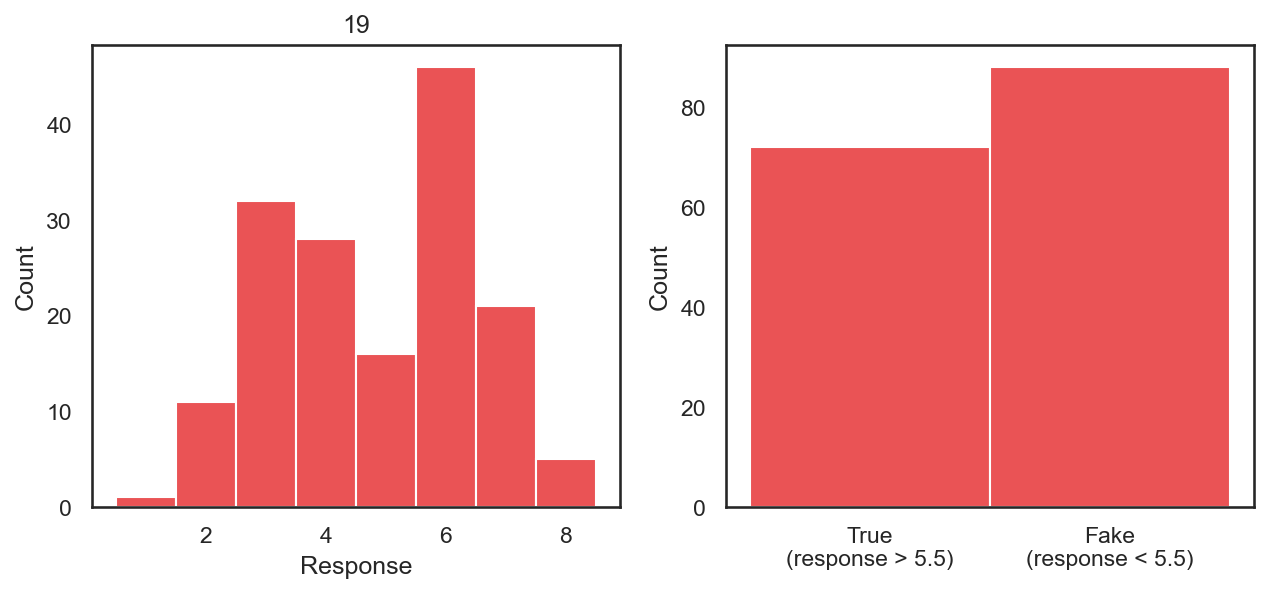

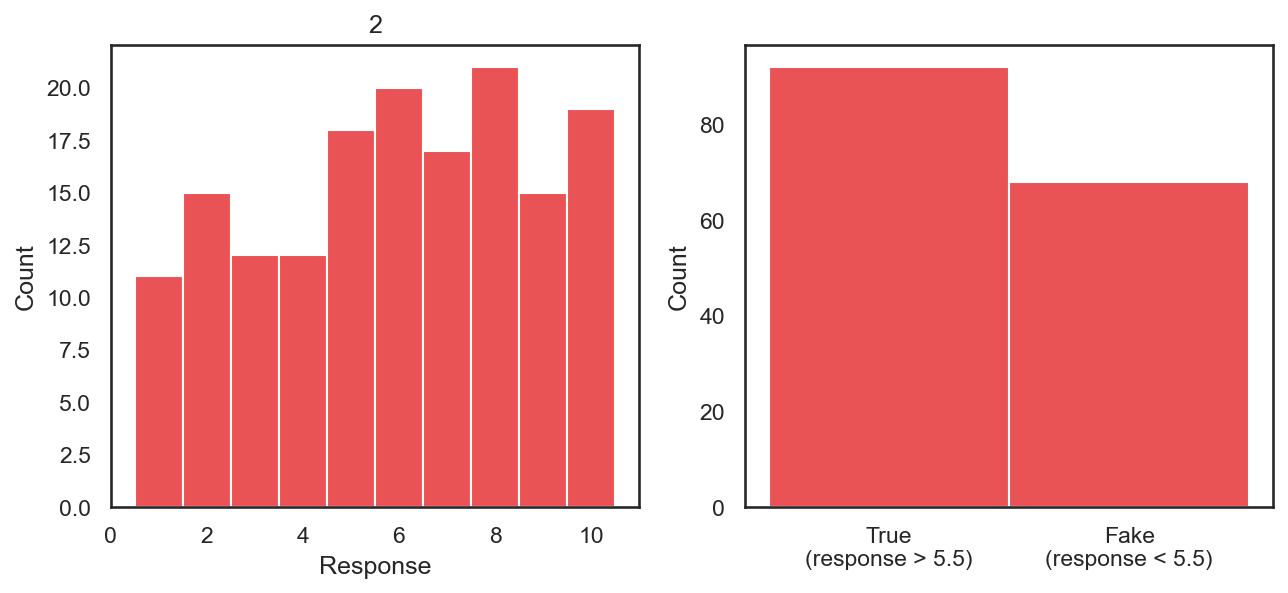

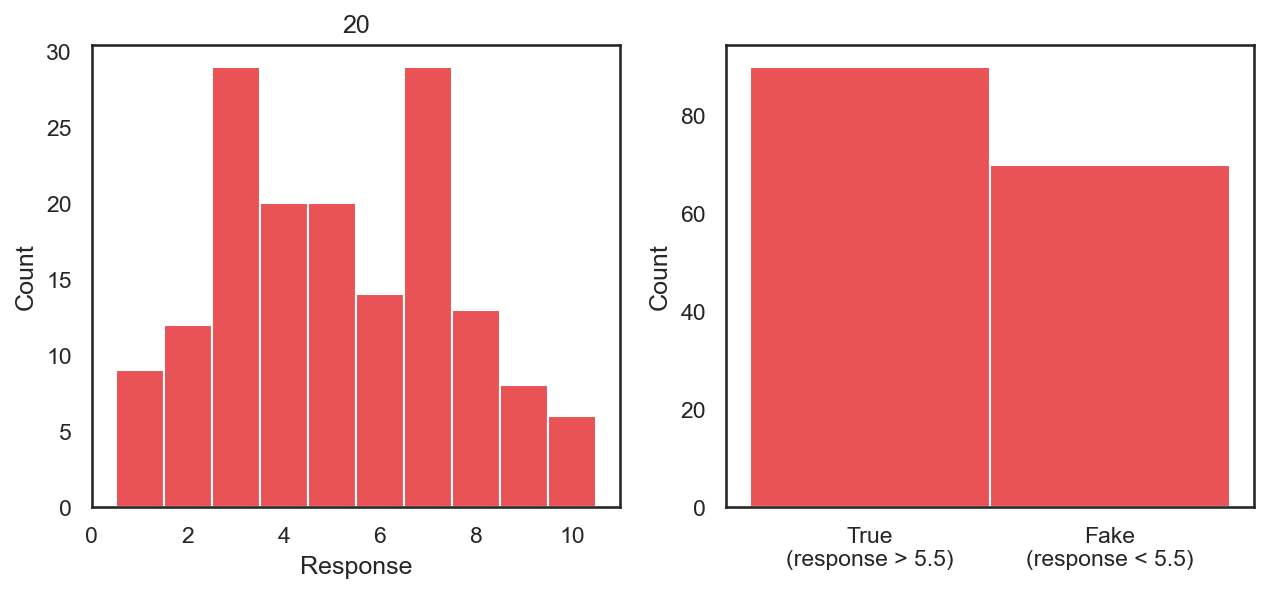

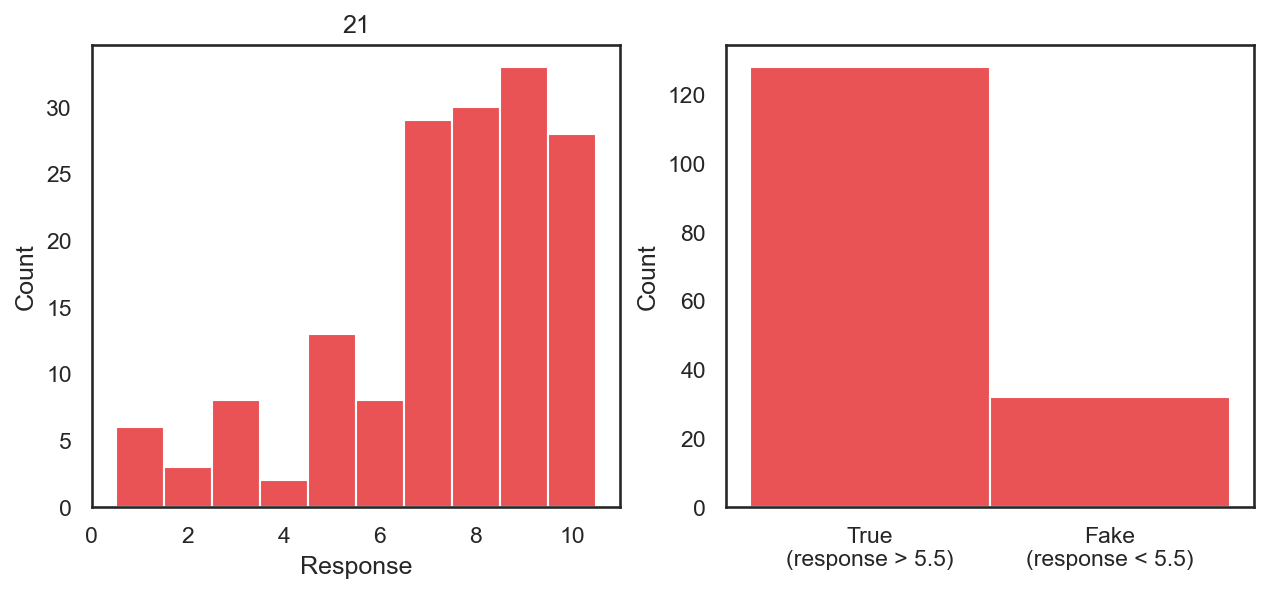

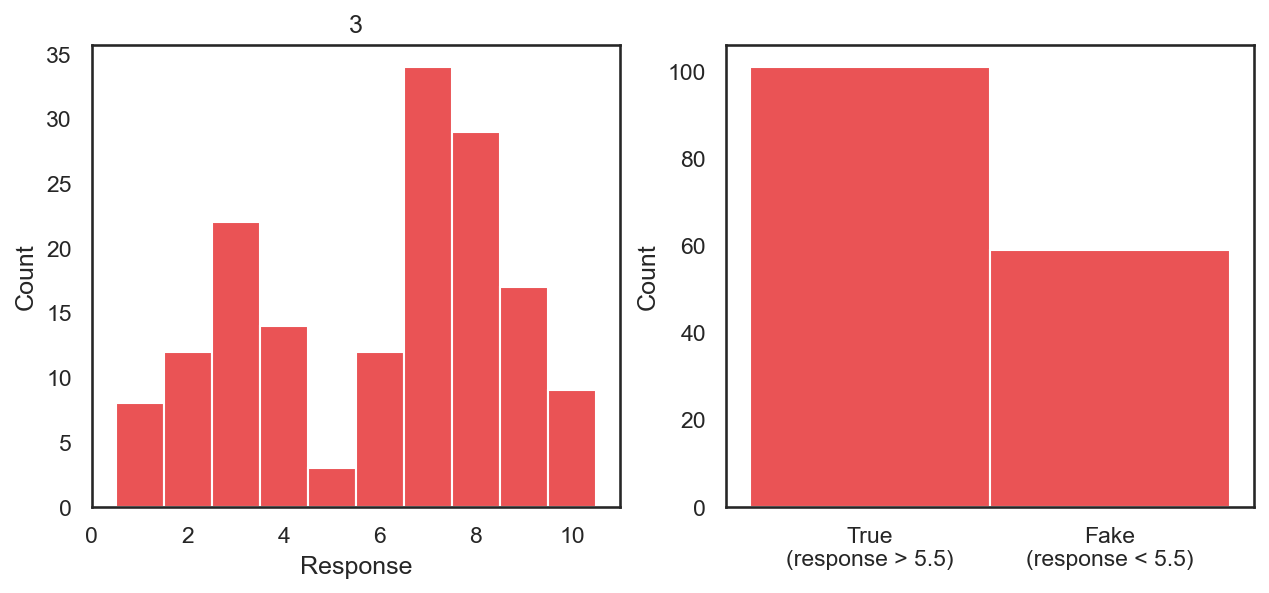

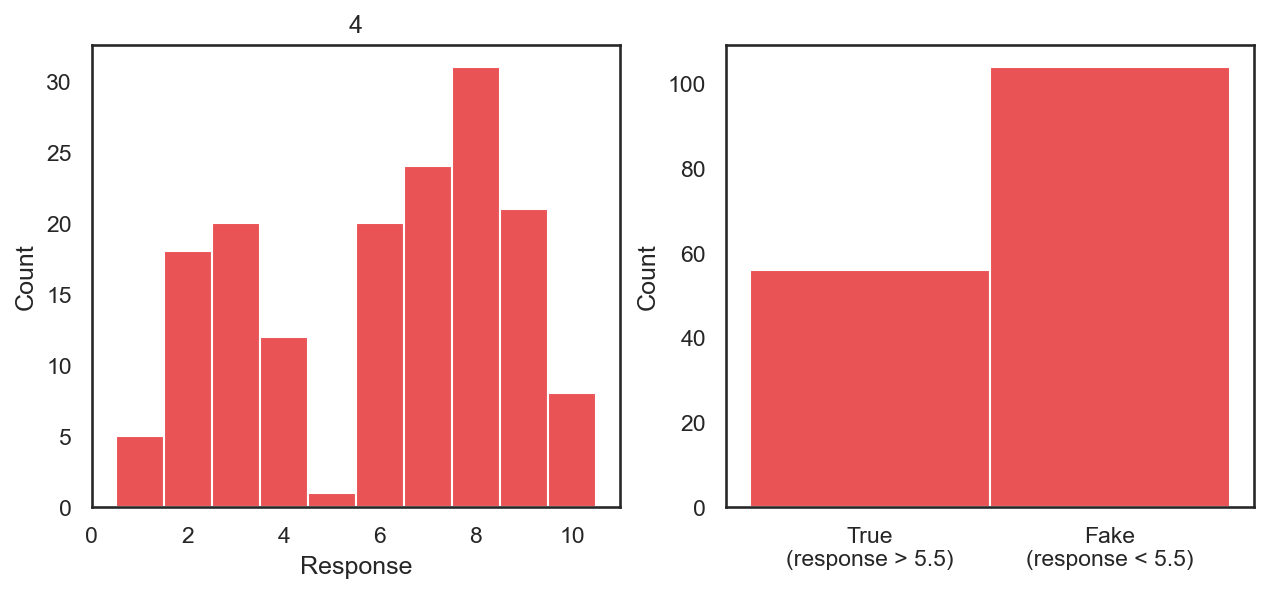

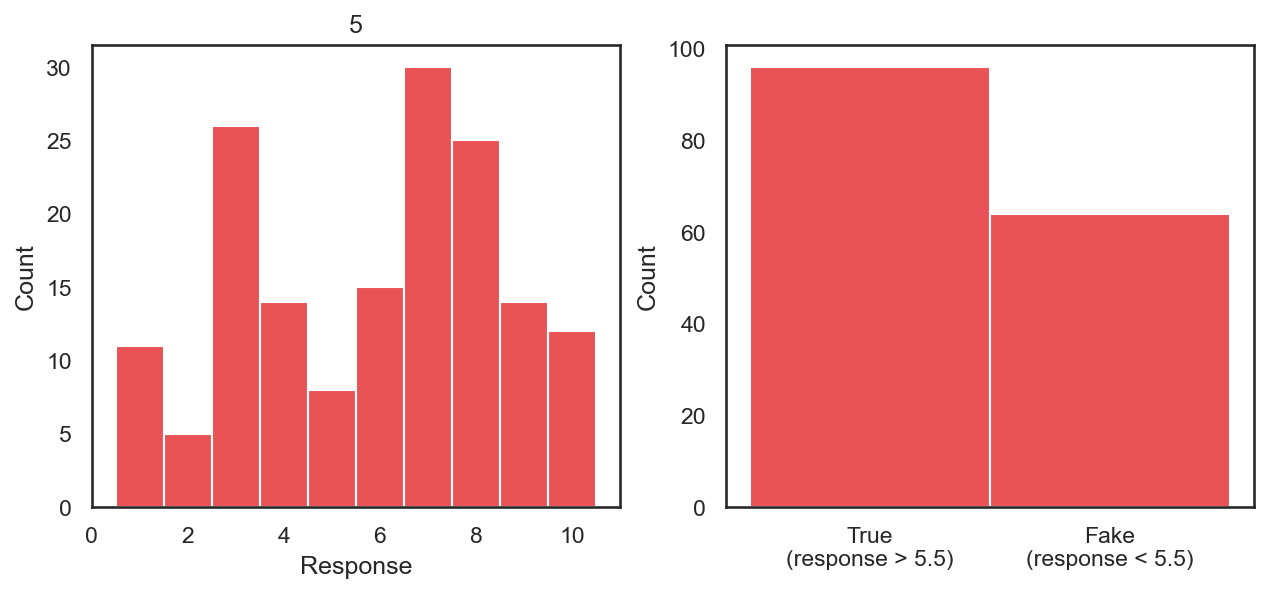

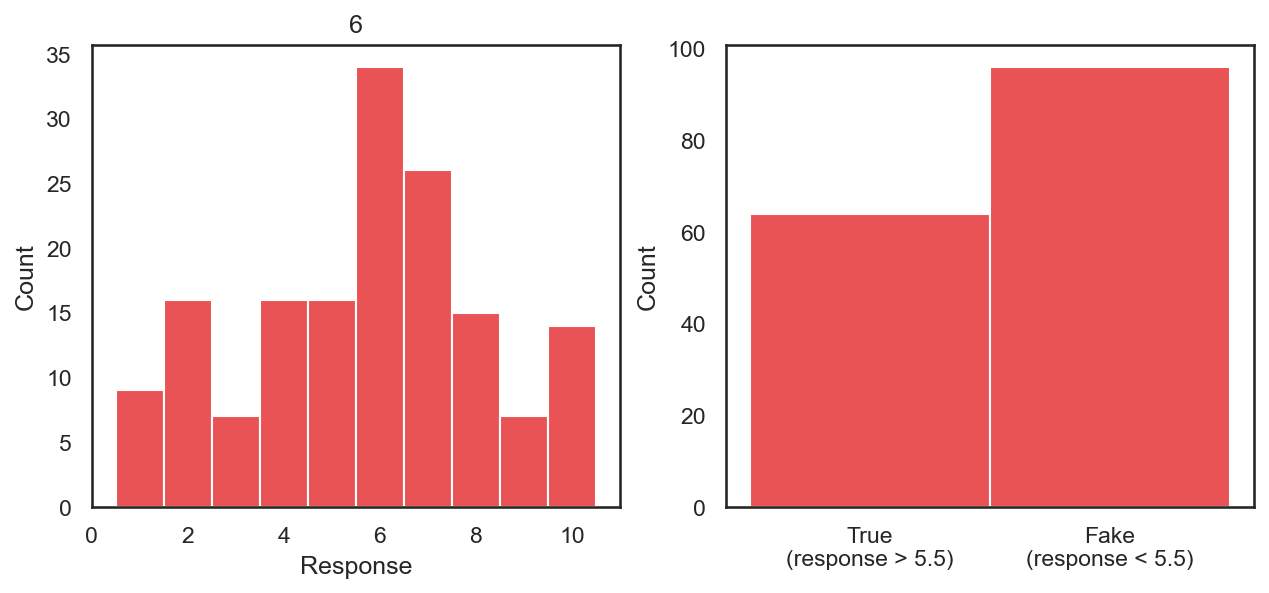

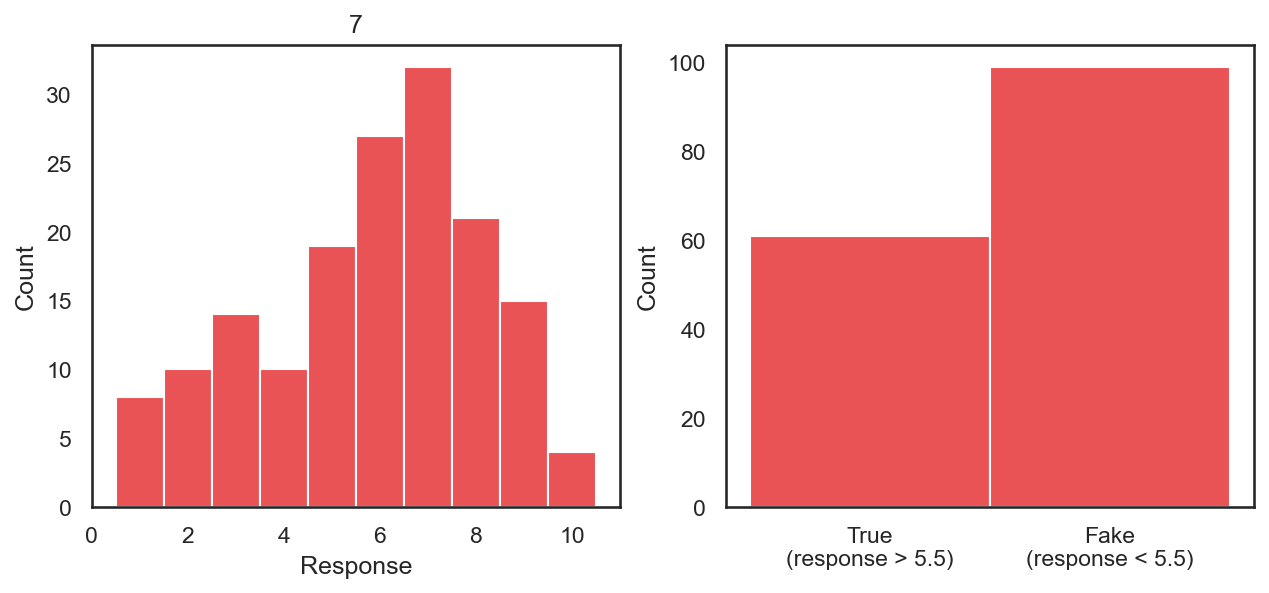

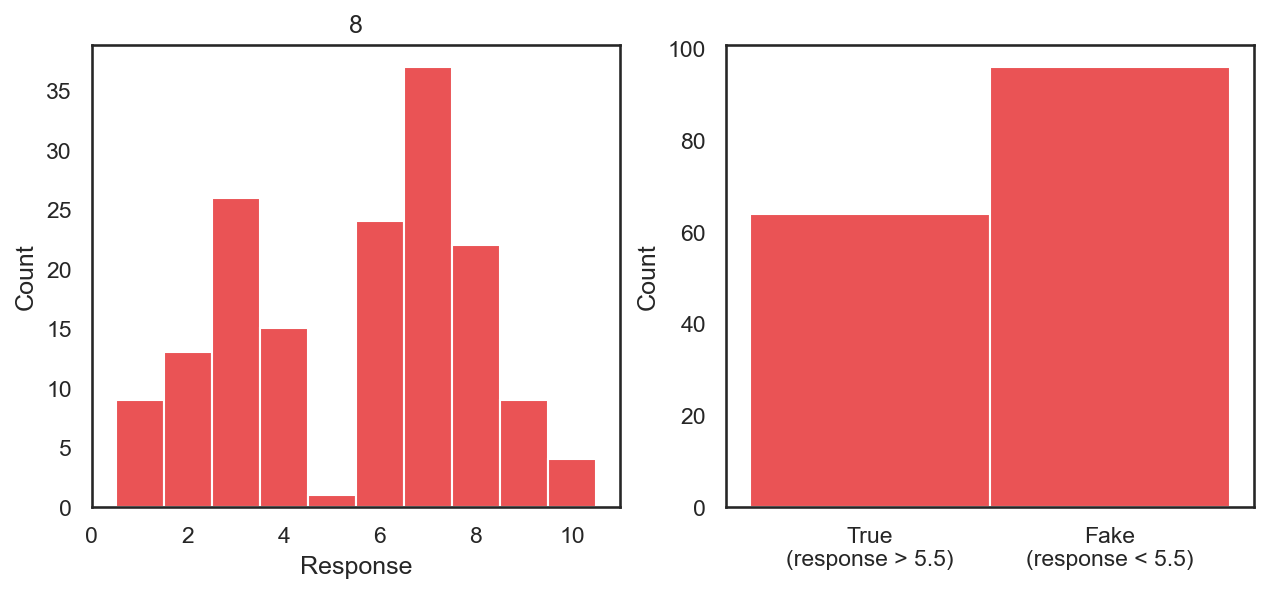

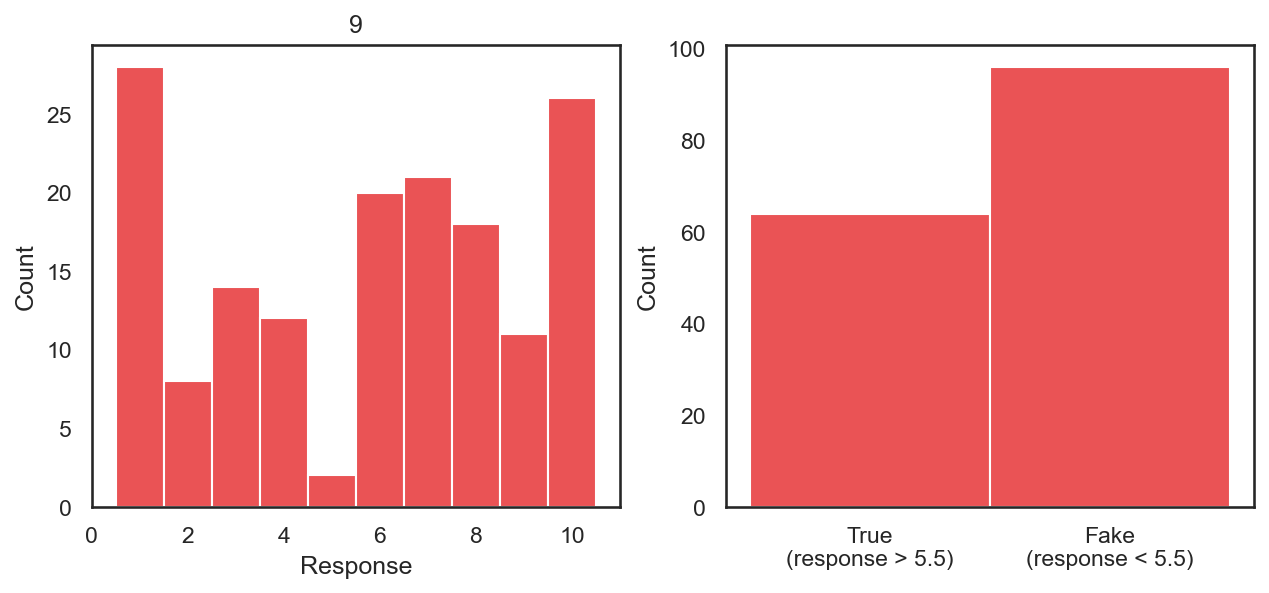

In [6]:
for subj in df['subject'].unique():
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    sns.histplot(data=df[df['subject']==subj], x='response', discrete=True, ax=axs[0])
    axs[0].set_xlabel('Response')
    axs[0].set_title(subj)
    
    axs[1].set_xticks([0, 1], labels=['True\n(response > 5.5)', 'Fake\n(response < 5.5)'])
    sns.histplot(data=df[df['subject']==subj], x='binary_resp', discrete=True, ax=axs[1])
    axs[1].set_xlabel('');

## All participants

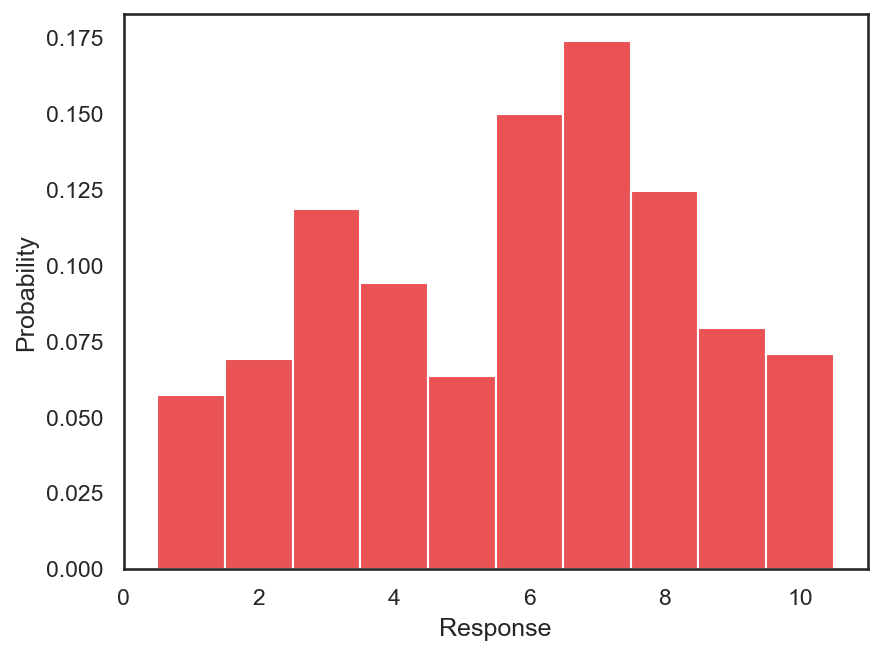

In [7]:
sns.histplot(data=df, x='response', discrete=True, stat='probability')
plt.xlabel('Response');

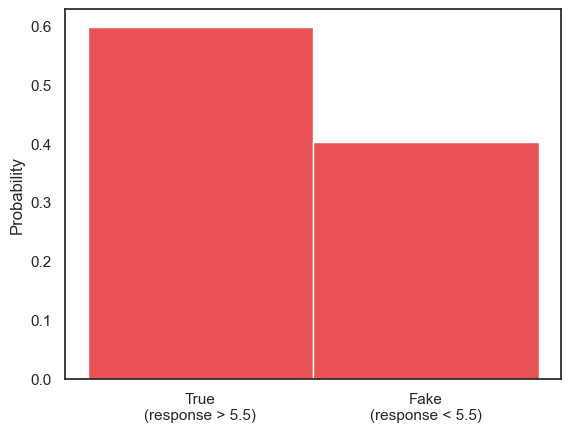

In [8]:
plt.xticks([0, 1], labels=['True\n(response > 5.5)', 'Fake\n(response < 5.5)'])
sns.histplot(data=df, x='binary_resp', discrete=True, stat='probability')
plt.xlabel('');

# Accuracy

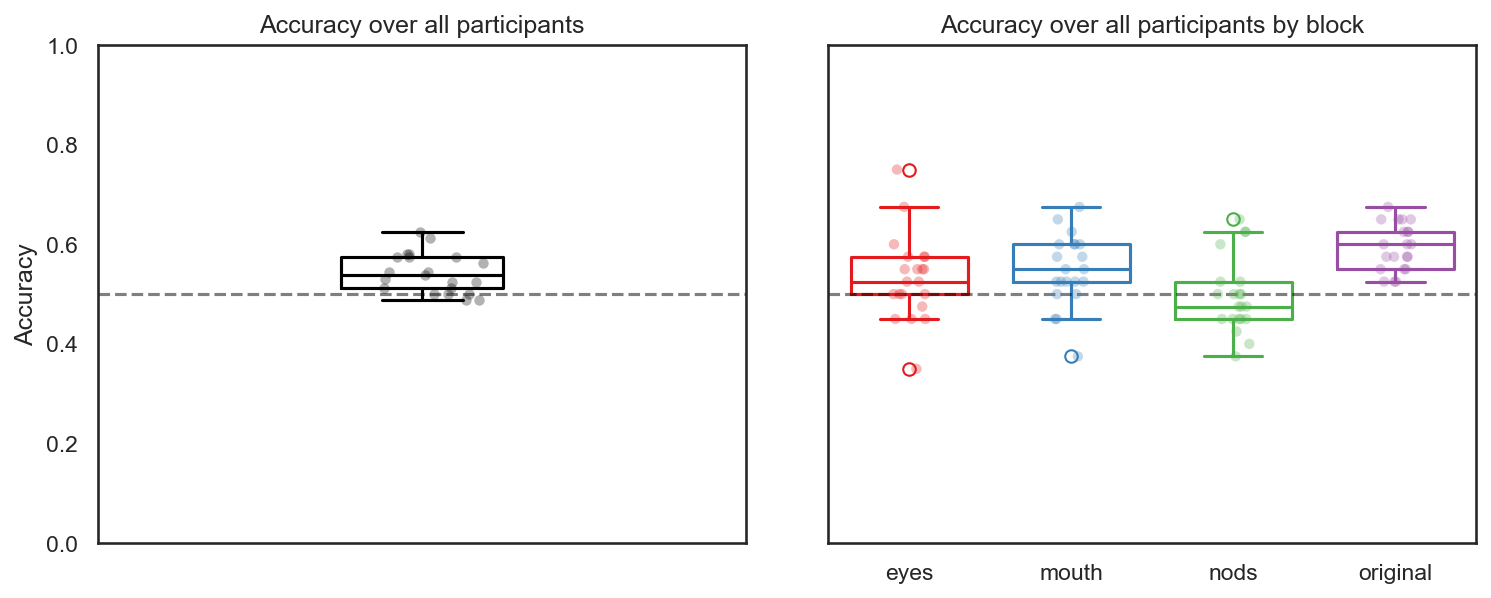

In [8]:
df_accuracy = df.groupby('subject').apply(lambda x: pd.Series({'accuracy': get_stats(x, 'accuracy')}), include_groups=False)
df_accuracy_block = df.groupby(['subject', 'block'], as_index=False).apply(lambda x: pd.Series({'accuracy': get_stats(x, 'accuracy')}), include_groups=False)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
plt.tight_layout(w_pad=2)
sns.boxplot(y='accuracy', data=df_accuracy, width=0.25, color='k', fill=False, ax=axs[0])
sns.stripplot(y='accuracy', data=df_accuracy, alpha=0.3, color='k', ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy')
axs[0].axhline(y=0.5, c='k', ls='--', alpha=0.5)
axs[0].set_title('Accuracy over all participants')

sns.boxplot(y='accuracy', x='block', hue='block', data=df_accuracy_block, fill=False, gap=0.1, ax=axs[1])
sns.stripplot(y='accuracy', x='block', hue='block', data=df_accuracy_block, alpha=0.3, legend=False, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('')
axs[1].axhline(y=0.5, c='k', ls='--', alpha=0.5)
axs[1].set_title('Accuracy over all participants by block');

## t-test for above chance performance

In [9]:
res = stats.ttest_1samp(df_accuracy['accuracy'].to_numpy(), 0.5)
print_ttest(res, text='t-test for above chance accuracy')

t-test for above chance accuracy: t(20)=4.85, p=0.00


## t-test for differences between blocks

In [10]:
for bp in [('eyes', 'mouth'), ('eyes', 'nods'), ('mouth', 'nods'), ('eyes', 'original'), ('mouth', 'original'), ('nods', 'original')]:
    print_ttest(
        stats.ttest_rel(
            df_accuracy_block[df_accuracy_block['block']==bp[0]]['accuracy'], 
            df_accuracy_block[df_accuracy_block['block']==bp[1]]['accuracy']
        ),
        text=f't-test {bp[0].capitalize()} vs. {bp[1].capitalize()} accuracy'
    )

t-test Eyes vs. Mouth accuracy: t(20)=-0.64, p=0.53
t-test Eyes vs. Nods accuracy: t(20)=1.40, p=0.18
t-test Mouth vs. Nods accuracy: t(20)=2.77, p=0.01
t-test Eyes vs. Original accuracy: t(20)=-3.15, p=0.01
t-test Mouth vs. Original accuracy: t(20)=-2.66, p=0.02
t-test Nods vs. Original accuracy: t(20)=-5.90, p=0.00


# d'

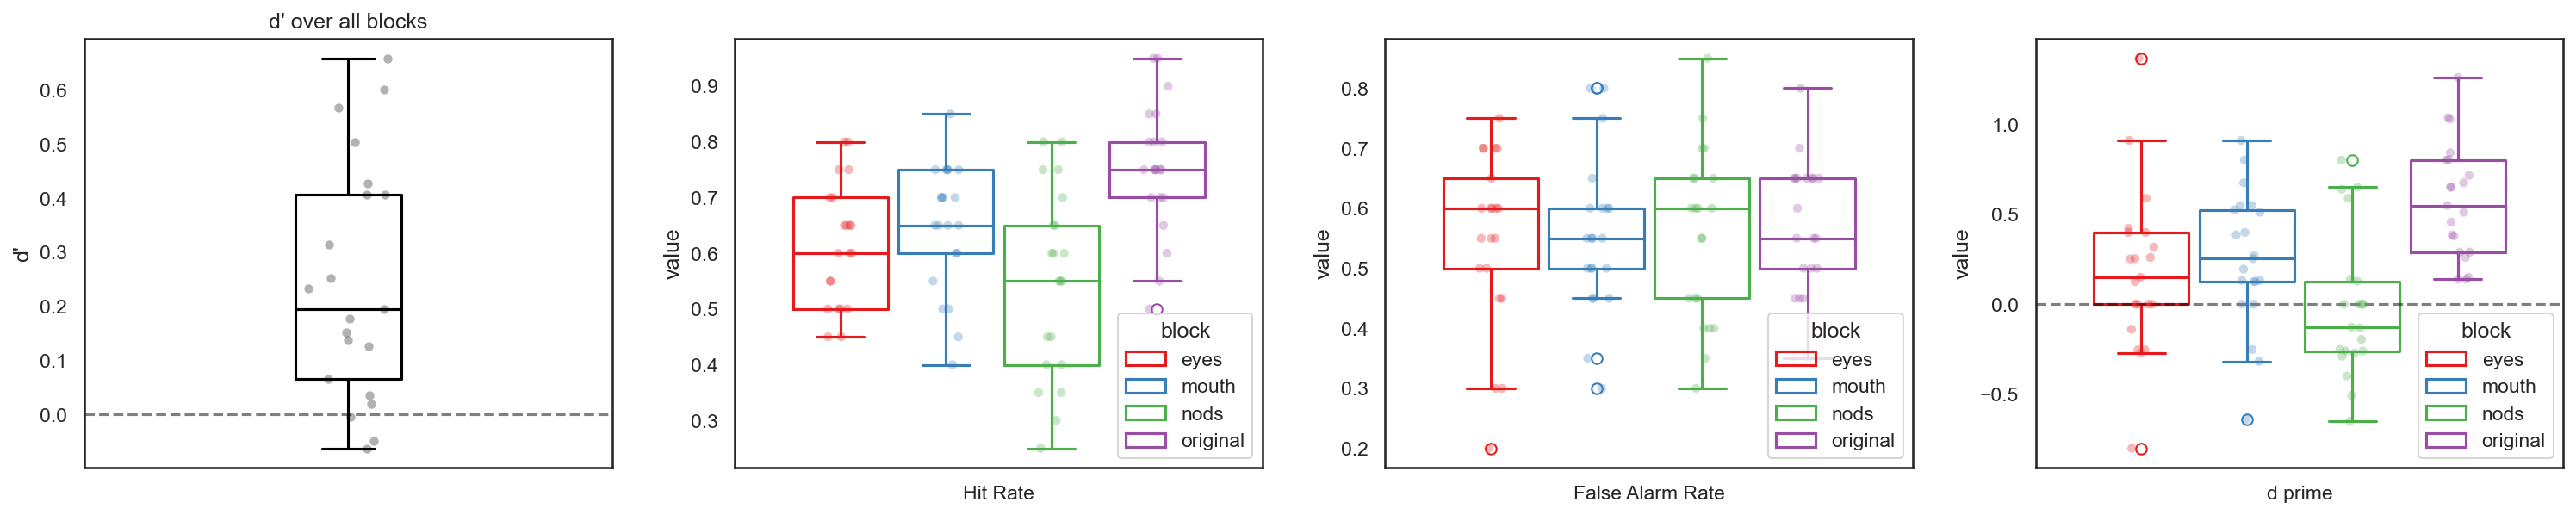

In [11]:
df_sdt = df.groupby(['subject', 'block'], as_index=False).apply(lambda x: get_stats(x, 'sdt'), include_groups=False).melt(id_vars=['subject', 'block'], var_name='Measure').reset_index(drop=True)

fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
plt.tight_layout(w_pad=3)
sns.boxplot(y='value', data=df_sdt[df_sdt['Measure']=='d prime'].groupby('subject').mean('value'), fill=False, width=0.2, color='k', ax=axs[0])
sns.stripplot(y='value', data=df_sdt[df_sdt['Measure']=='d prime'].groupby('subject').mean('value'), alpha=0.3, dodge=True, legend=False, color='k', ax=axs[0])
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].set_ylabel("d'")
axs[0].axhline(y=0, linestyle='--', color='k', alpha=0.5)
axs[0].set_title("d' over all blocks")

sns.boxplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='Hit Rate'], fill=False, gap=.1, ax=axs[1])
sns.stripplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='Hit Rate'], alpha=0.3, dodge=True, legend=False, ax=axs[1])
axs[1].set_xlabel('')

sns.boxplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='False Alarm Rate'], fill=False, gap=.1, ax=axs[2])
sns.stripplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='False Alarm Rate'], alpha=0.3, dodge=True, legend=False, ax=axs[2])
axs[2].set_xlabel('')

sns.boxplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='d prime'], fill=False, gap=.1, ax=axs[3])
sns.stripplot(y='value', x='Measure', hue='block', data=df_sdt[df_sdt['Measure']=='d prime'], alpha=0.3, dodge=True, legend=False, ax=axs[3])
axs[3].set_xlabel('')
axs[3].axhline(y=0, linestyle='--', color='k', alpha=0.5);

In [12]:
# Define measure to be compared
measure = 'd prime'

## Compare performance between blocks for individual participants

<Axes: xlabel='block', ylabel='subject'>

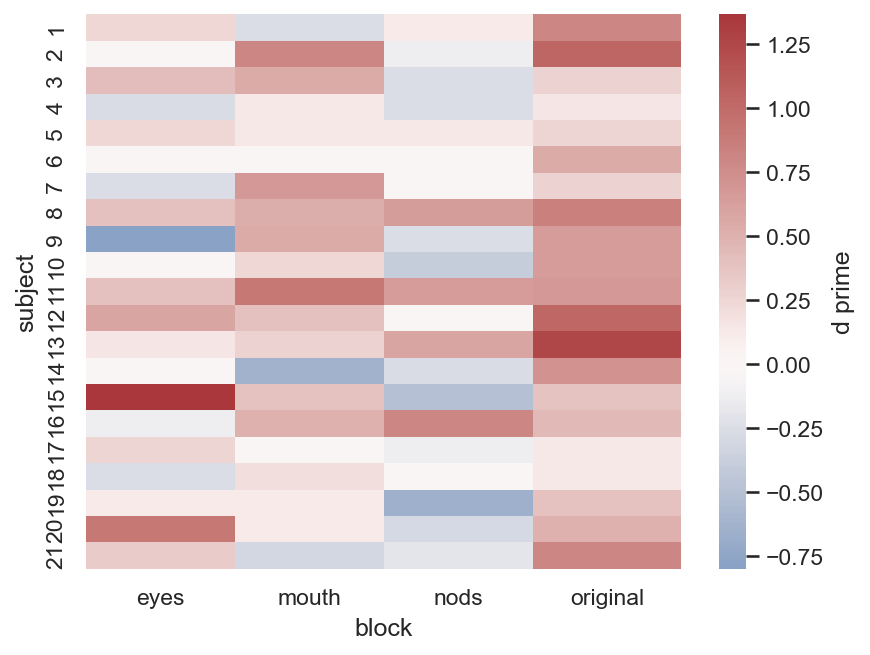

In [13]:
test =df_sdt[df_sdt['Measure']==measure].pivot(index="subject", columns="block", values="value")
sns.heatmap(test, cmap=sns.color_palette('vlag', as_cmap=True), center=0, cbar_kws={'label': measure})

## t-test for above chance performance

In [14]:
res = stats.ttest_1samp(
    df_sdt[df_sdt['Measure']==measure].groupby('subject').mean('value')['value'].to_numpy(), 
    0
)
print_ttest(res, text=f't-test for above chance {measure}')

t-test for above chance d prime: t(20)=5.12, p=0.00


## t-test for differences between blocks

In [15]:
for bp in [('eyes', 'mouth'), ('eyes', 'nods'), ('mouth', 'nods'), ('eyes', 'original'), ('mouth', 'original'), ('nods', 'original')]:
    print_ttest(
        stats.ttest_rel(
            df_sdt[(df_sdt['Measure']==measure) & (df_sdt['block']==bp[0])]['value'], 
            df_sdt[(df_sdt['Measure']==measure) & (df_sdt['block']==bp[1])]['value']
        ),
        text=f't-test {bp[0].capitalize()} vs. {bp[1].capitalize()} {measure}'
    )

t-test Eyes vs. Mouth d prime: t(20)=-0.59, p=0.56
t-test Eyes vs. Nods d prime: t(20)=1.44, p=0.17
t-test Mouth vs. Nods d prime: t(20)=2.80, p=0.01
t-test Eyes vs. Original d prime: t(20)=-3.42, p=0.00
t-test Mouth vs. Original d prime: t(20)=-3.04, p=0.01
t-test Nods vs. Original d prime: t(20)=-6.47, p=0.00


# SDT category vs. change in genuineness

In [16]:
# Define participants to exclude
exclude_list = []
df = df[~df['subject'].isin(exclude_list)]

# Strip paths to get trial names
df['trial'] = df['video_path'].apply(lambda x: x.split('/')[-1])
df

,subject,age,sex,trial_num,block_num,block,video_path,audio_path,condition,category,duration,eye_fit,mouth_fit,genuineness,response,z_response,binary_resp,category_new,trial
0,1,22.0,m,1,1,eyes,./stimuli/eyes/52_3.mov,./stimuli/audio/52/3_audio.wav,true,hit,10,0.280581,0.210438,0.750000,8.0,1.086711,true,hit,52_3.mov
1,1,22.0,m,2,1,eyes,./stimuli/eyes/58_1_2.mov,./stimuli/audio/58/1_2_audio.wav,fake,fa,14,0.020211,0.104356,0.600000,3.0,-0.799122,fake,cr,58_1_2.mov
2,1,22.0,m,3,1,eyes,./stimuli/eyes/2_2_3.mov,./stimuli/audio/2/2_3_audio.wav,fake,fa,8,-0.050236,0.129175,0.571429,7.0,0.709545,true,fa,2_2_3.mov
3,1,22.0,m,4,1,eyes,./stimuli/eyes/5_1.mov,./stimuli/audio/5/1_audio.wav,true,hit,19,0.331329,0.271282,1.000000,4.0,-0.421955,fake,miss,5_1.mov
4,1,22.0,m,5,1,eyes,./stimuli/eyes/14_2.mov,./stimuli/audio/14/2_audio.wav,true,miss,7,-0.168140,0.457204,0.400000,7.0,0.709545,true,hit,14_2.mov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9,21.0,f,36,4,original,./stimuli/original/60_4_6.mov,./stimuli/audio/60/4_6_audio.wav,fake,cr,9,0.253970,-0.404008,0.333333,3.0,-0.858096,fake,cr,60_4_6.mov
3356,9,21.0,f,37,4,original,./stimuli/original/45_3.mov,./stimuli/audio/45/3_audio.wav,true,miss,7,0.038899,0.168890,0.125000,6.0,0.090950,true,hit,45_3.mov
3357,9,21.0,f,38,4,original,./stimuli/original/22_19_3_23_2.mov,./stimuli/audio/22/19_3_23_2_audio.wav,fake,fa,11,-0.043332,0.084844,0.600000,10.0,1.356346,true,fa,22_19_3_23_2.mov
3358,9,21.0,f,39,4,original,./stimuli/original/56_2_3.mov,./stimuli/audio/56/2_3_audio.wav,fake,fa,11,-0.066640,0.508794,0.750000,8.0,0.723648,true,fa,56_2_3.mov


## Change in genuineness across categories

In [17]:
def get_idx(c):
    match c:
        case 'eyes':
            return 0
        case 'mouth':
            return 1
        case 'nods':
            return 2
        case 'original':
            return 3
        case _:
            raise ValueError(f"Value to match cannot be {c}. Must be one of: ['eyes', 'mouth', 'nods', 'original']")


def delta_gen(data, comparand=None):
    idx = get_idx(comparand)
    # Create DataFrame with columns for the value against which change in genuineness is to be measured
    df_resp = data.groupby(['subject', 'trial'], as_index=False).apply(lambda x: 
                                                                       pd.Series({comparand: x.iloc[idx]['response'], f'z_{comparand}': x.iloc[idx]['z_response']}), 
                                                                       include_groups=False)
    df = data.merge(df_resp, how='inner', on=['subject', 'trial'])

    # Change in response
    df[f'delta_{comparand}'] = df['response'] - df[comparand]
    # Change in z-scored response
    df[f'delta_z_{comparand}'] = df['z_response'] - df[f'z_{comparand}']
    # z-scored change in response
    df[f'z_delta_{comparand}'] = df.groupby('subject')[f'delta_{comparand}'].transform(lambda x: StandardScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())

    fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
    for y, ax in zip([f'delta_{comparand}', f'delta_z_{comparand}', f'z_delta_{comparand}'], axs.ravel()):
        sns.barplot(
            data=df.groupby(['subject','category','block'], as_index=False)[y].mean(), 
            x='category', 
            y=y, 
            hue='block',
            order=['hit', 'miss', 'cr', 'fa'], 
            ax=ax
        )
        ax.axhline(y=0, linestyle='--', color='k', alpha=0.5)

    return df

### Plot change w.r.t Original

T  dof alternative     p-val           CI95%  \
category block                                                               
cr       eyes  T-test  1.026578   20   two-sided  0.316876   [-0.21, 0.62]   
         mouth T-test  1.343906   20   two-sided  0.194027   [-0.14, 0.64]   
         nods  T-test  2.173301   20   two-sided  0.041944    [0.02, 0.77]   
fa       eyes  T-test  0.862977   20   two-sided  0.398381   [-0.15, 0.36]   
         mouth T-test -1.205361   20   two-sided  0.242132   [-0.62, 0.17]   
         nods  T-test -1.794028   20   two-sided  0.087942    [-0.8, 0.06]   
hit      eyes  T-test -4.544628   20   two-sided  0.000197  [-1.47, -0.54]   
         mouth T-test -4.869258   20   two-sided  0.000093    [-1.0, -0.4]   
         nods  T-test -6.529104   20   two-sided  0.000002  [-2.17, -1.12]   
miss     eyes  T-test -1.546894   20   two-sided  0.137567   [-0.89, 0.13]   
         mouth T-test -3.423422   20   two-sided  0.002692  [-1.13, -0.27]   
         nods  T-test -4.356742   20   two-sided  0.000306   [-1.3, -0.46]   

                        cohen-d      BF10     power  
category block                                       
cr       eyes  T-test  0.224018     0.363  0.164678  
         mouth T-test  0.293264     0.499  0.248811  
         nods  T-test  0.474253     1.568  0.543196  
fa       eyes  T-test  0.188317     0.317  0.130292  
         mouth T-test  0.263031      0.43  0.209353  
         nods  T-test  0.391489     0.884  0.400627  
hit      eyes  T-test  0.991719   151.008  0.990796  
         mouth T-test  1.062559   295.186  0.996145  
         nods  T-test  1.424767  8341.547  0.999988  
miss     eyes  T-test  0.337560     0.636  0.313415  
         mouth T-test  0.747052    15.354  0.902342  
         nods  T-test  0.950719    102.45  0.985349

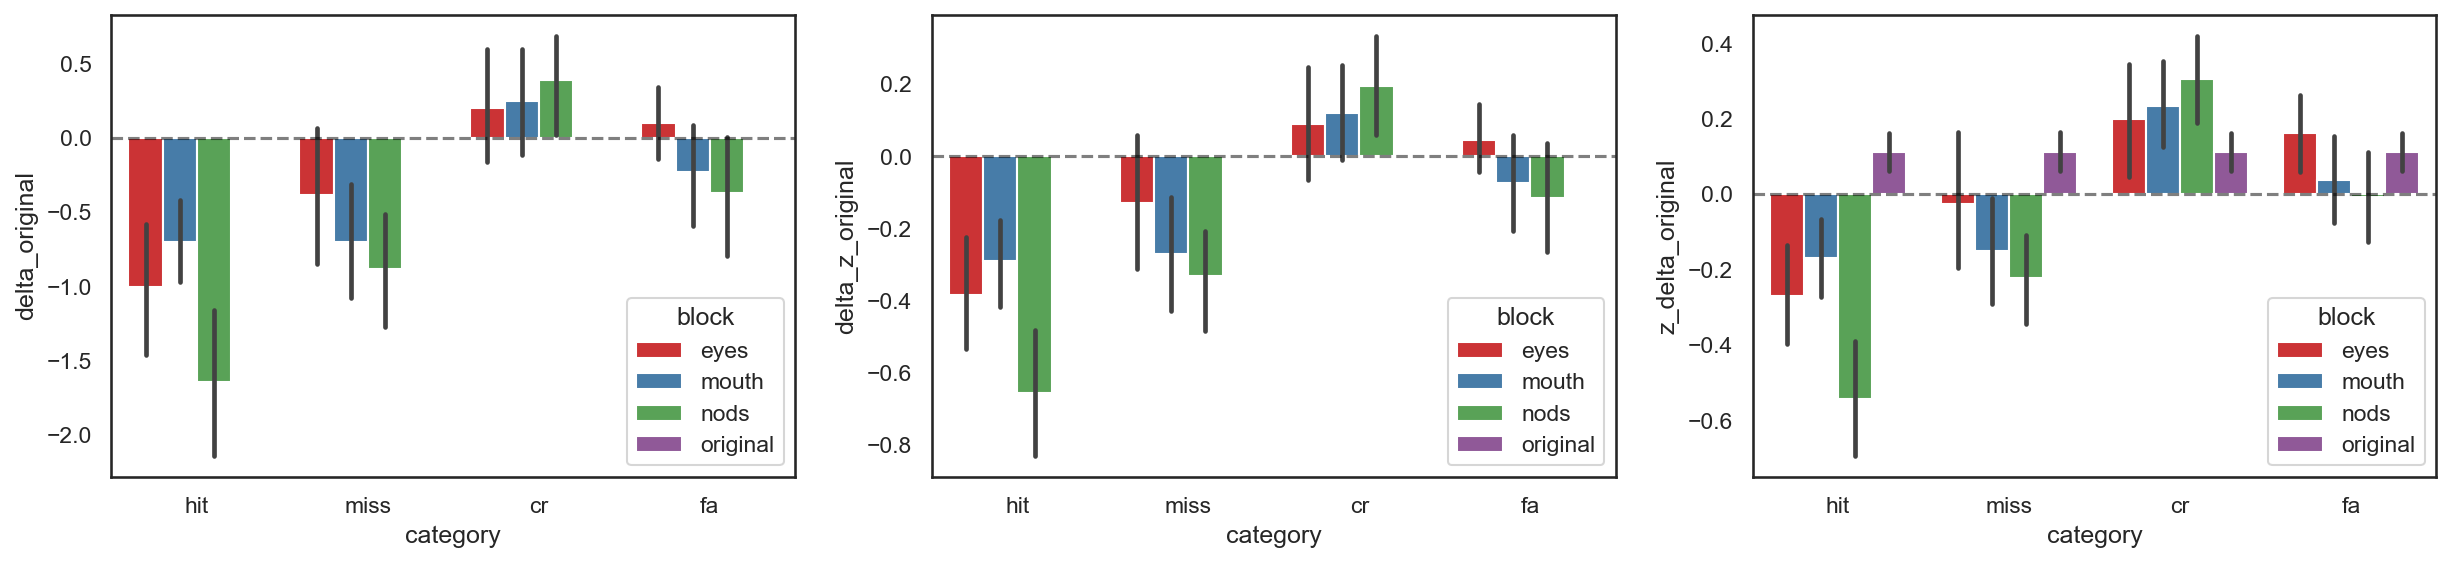

In [18]:
df_gen_original = delta_gen(df, comparand='original')

(df_gen_original[df_gen_original.block != 'original']
 .groupby(['subject','category','block'], as_index=False).delta_original.mean()
 .groupby(['category','block']).delta_original
 .apply(lambda x: pg.ttest(x,0)))

### Plot change w.r.t Eyes

T  dof alternative     p-val           CI95%  \
category block                                                                  
cr       mouth    T-test  0.187908   20   two-sided  0.852842   [-0.48, 0.58]   
         nods     T-test  0.852635   20   two-sided  0.403957   [-0.27, 0.64]   
         original T-test -1.026578   20   two-sided  0.316876   [-0.62, 0.21]   
fa       mouth    T-test -1.901500   20   two-sided  0.071742    [-0.7, 0.03]   
         nods     T-test -2.386778   20   two-sided  0.026989  [-0.89, -0.06]   
         original T-test -0.862977   20   two-sided  0.398381   [-0.36, 0.15]   
hit      mouth    T-test  1.294211   20   two-sided  0.210338    [-0.19, 0.8]   
         nods     T-test -3.024900   20   two-sided  0.006690   [-1.08, -0.2]   
         original T-test  4.544628   20   two-sided  0.000197    [0.54, 1.47]   
miss     mouth    T-test -1.333772   20   two-sided  0.197270   [-0.82, 0.18]   
         nods     T-test -2.148817   20   two-sided  0.044075  [-0.99, -0.01]   
         original T-test  1.546894   20   two-sided  0.137567   [-0.13, 0.89]   

                           cohen-d     BF10     power  
category block                                         
cr       mouth    T-test  0.041005    0.231  0.053681  
         nods     T-test  0.186060    0.315  0.128330  
         original T-test  0.224018    0.363  0.164678  
fa       mouth    T-test  0.414941    1.032  0.440512  
         nods     T-test  0.520838    2.231  0.622191  
         original T-test  0.188317    0.317  0.130292  
hit      mouth    T-test  0.282420    0.473  0.234195  
         nods     T-test  0.660087    7.073  0.820427  
         original T-test  0.991719  151.008  0.990796  
miss     mouth    T-test  0.291053    0.494  0.245790  
         nods     T-test  0.468910    1.508  0.533962  
         original T-test  0.337560    0.636  0.313415

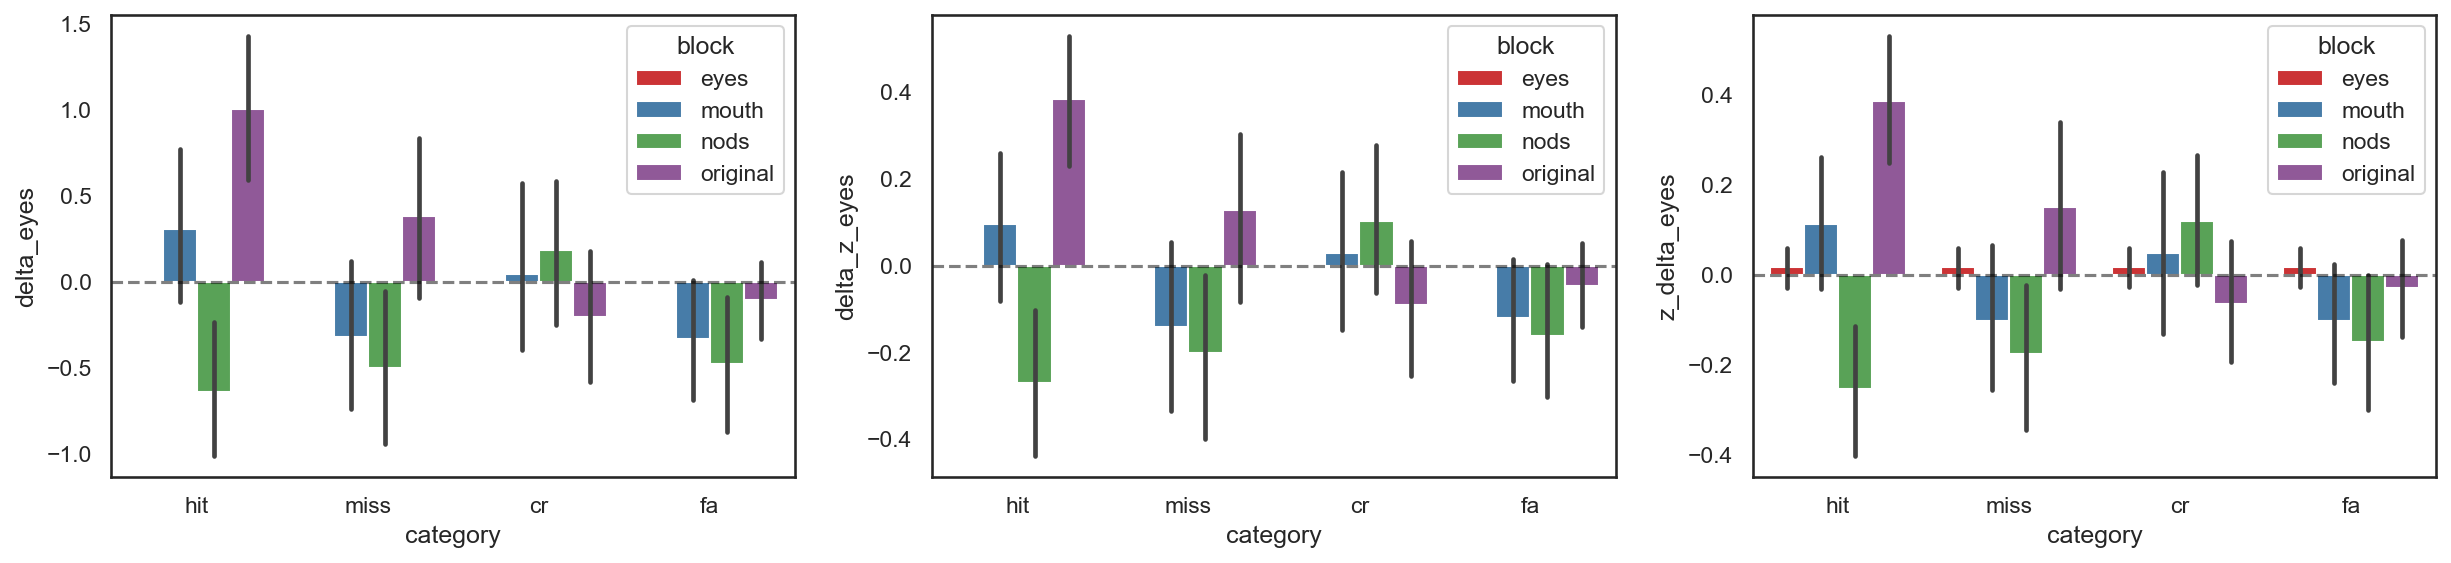

In [19]:
df_gen_eyes = delta_gen(df, comparand='eyes')

(df_gen_eyes[df_gen_eyes['block']!='eyes']
 .groupby(['subject','category','block'], as_index=False).delta_eyes.mean()
 .groupby(['category','block']).delta_eyes
 .apply(lambda x: pg.ttest(x, 0)))

### Plot change w.r.t genuineness from Experiment 1

Text(0, 0.5, 'Change in genuineness')

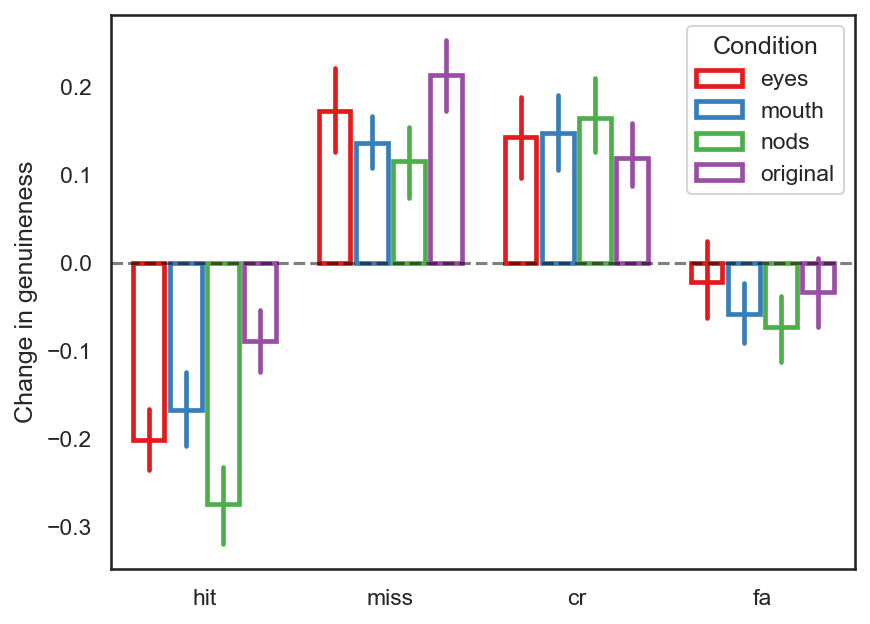

In [20]:
# Scale responses to range [0, 1] from [1, 10]
df['scaled_response'] = df.groupby('subject').response.transform(lambda x: MinMaxScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())
df['delta_gen'] = df.scaled_response - df.genuineness
df['z_delta_gen'] = df.groupby('subject').delta_gen.transform(lambda x: StandardScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())

sns.barplot(
    data=df.groupby(['subject','category','block'], as_index=False).delta_gen.mean(), 
    x='category', 
    y='delta_gen', 
    hue='block',
    order=['hit', 'miss', 'cr', 'fa'],
    fill=False,
    gap=0.15
)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.5)
plt.legend(title='Condition')
plt.xlabel('')
plt.ylabel('Change in genuineness')

### Plot for ESCAN poster

Text(0, 0.5, 'Change in  genuineness')

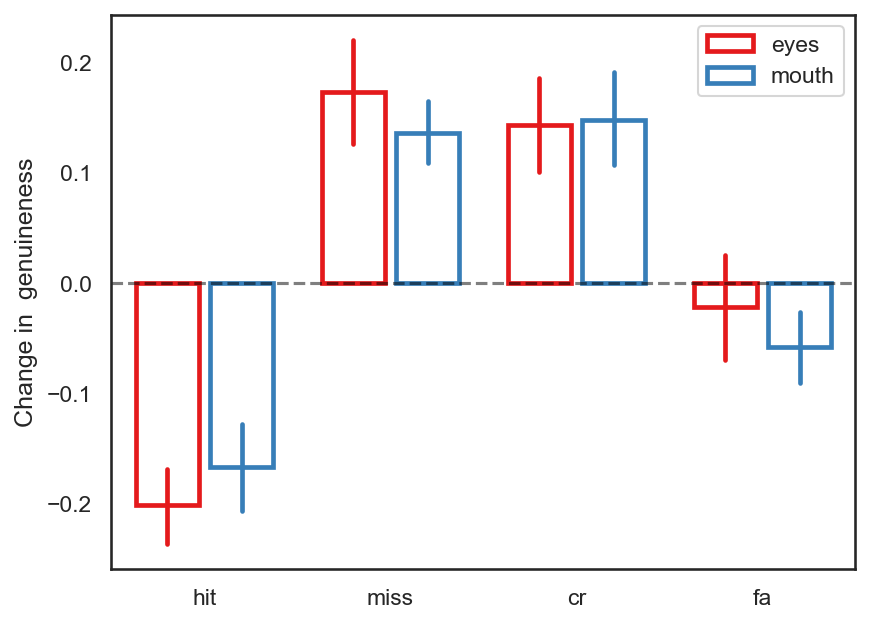

In [24]:
# Scale responses to range [0, 1] from [1, 10]
df['scaled_response'] = df.groupby('subject').response.transform(lambda x: MinMaxScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())
df['delta_gen'] = df.scaled_response - df.genuineness
df['z_delta_gen'] = df.groupby('subject').delta_gen.transform(lambda x: StandardScaler().fit_transform(x.to_numpy().reshape(-1, 1)).flatten())

escan = df[(df.block!='nods') & (df.block!='original')]
sns.barplot(
    data=escan.groupby(['subject','category','block'], as_index=False).delta_gen.mean(), 
    x='category', 
    y='delta_gen', 
    hue='block',
    order=['hit', 'miss', 'cr', 'fa'],
    fill=False,
    gap=0.15
)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.5)
plt.legend(title='')
plt.xlabel('')
plt.ylabel('Change in  genuineness')

In [22]:
(df
 .groupby(['subject','category','block'], as_index=False).delta_gen.mean()
 .groupby(['category','block']).delta_gen
 .apply(lambda x: pg.ttest(x, 0)))

T  dof alternative         p-val  \
category block                                                       
cr       eyes     T-test   6.160239   20   two-sided  5.103936e-06   
         mouth    T-test   6.557147   20   two-sided  2.174297e-06   
         nods     T-test   7.356116   20   two-sided  4.155725e-07   
         original T-test   6.347307   20   two-sided  3.405271e-06   
fa       eyes     T-test  -0.914841   20   two-sided  3.711735e-01   
         mouth    T-test  -3.273284   20   two-sided  3.802365e-03   
         nods     T-test  -3.611217   20   two-sided  1.742343e-03   
         original T-test  -1.506335   20   two-sided  1.476134e-01   
hit      eyes     T-test -11.463187   20   two-sided  3.038863e-10   
         mouth    T-test  -7.825895   20   two-sided  1.634828e-07   
         nods     T-test -11.318747   20   two-sided  3.791421e-10   
         original T-test  -4.839044   20   two-sided  9.959799e-05   
miss     eyes     T-test   7.124890   20   two-sided  6.649890e-07   
         mouth    T-test   8.650126   20   two-sided  3.414945e-08   
         nods     T-test   5.450219   20   two-sided  2.463875e-05   
         original T-test   9.822043   20   two-sided  4.275283e-09   

                                   CI95%   cohen-d       BF10     power  
category block                                                           
cr       eyes     T-test    [0.09, 0.19]  1.344274   4045.434  0.999949  
         mouth    T-test      [0.1, 0.2]  1.430887   8808.526  0.999990  
         nods     T-test    [0.12, 0.21]  1.605236  4.017e+04  1.000000  
         original T-test    [0.08, 0.16]  1.385096   5848.744  0.999976  
fa       eyes     T-test   [-0.07, 0.03]  0.199635       0.33  0.140511  
         mouth    T-test  [-0.09, -0.02]  0.714289     11.423  0.875468  
         nods     T-test  [-0.11, -0.03]  0.788032     22.338  0.929633  
         original T-test   [-0.08, 0.01]  0.328709      0.605  0.299923  
hit      eyes     T-test  [-0.24, -0.16]  2.501473  3.293e+07  1.000000  
         mouth    T-test  [-0.21, -0.12]  1.707750  9.488e+04  1.000000  
         nods     T-test  [-0.32, -0.22]  2.469953  2.677e+07  1.000000  
         original T-test  [-0.13, -0.05]  1.055966    277.353  0.995805  
miss     eyes     T-test    [0.12, 0.22]  1.554778  2.607e+04  0.999999  
         mouth    T-test     [0.1, 0.17]  1.887612  4.039e+05  1.000000  
         nods     T-test    [0.07, 0.16]  1.189335     971.56  0.999345  
         original T-test    [0.17, 0.26]  2.143345  2.786e+06  1.000000

In [23]:
ttests = []

for category in df.category.unique():
    for pair in itertools.combinations(df.block.unique(), 2):
        x = df[(df.category==category) & (df.block==pair[0])].delta_gen
        y = df[(df.category==category) & (df.block==pair[1])].delta_gen
        test = pg.ttest(x, y, paired=True)
        test['category'] = category
        test['comparison'] = f'{pair[0].capitalize()} vs. {pair[1].capitalize()}'
        ttests.append(test)

In [24]:
df_ttest = pd.concat(ttests).reset_index(drop=True)
df_ttest['sig'] = df_ttest.apply(lambda x: '*' if x['p-val'] < 0.05 else '', axis=1)
df_ttest.pivot(index=['comparison'], columns=['category'], values=['p-val', 'sig'])

p-val                               sig            
category                  cr        fa       hit      miss  cr fa hit miss
comparison                                                                
Eyes vs. Mouth       0.83607  0.143171  0.179824  0.191898                
Eyes vs. Nods       0.344476  0.029573  0.008724  0.039457      *   *    *
Eyes vs. Original   0.352727  0.590349  0.000004   0.15456          *     
Mouth vs. Nods      0.486593  0.525906  0.000016  0.460781          *     
Mouth vs. Original  0.247118  0.279584  0.000158  0.010712          *    *
Nods vs. Original   0.059847  0.075769       0.0   0.00103          *    *

# Wilcoxon signed-rank test (non-parametric)

In [25]:
for category in df.category.unique():
    df_sub = df[df.category==category]
    x = df_sub[df_sub.block=='eyes'].response
    y = df_sub[df_sub.block=='mouth'].response
    print(category)
    print(pg.wilcoxon(x, y))
    print("****************************************************************")

hit
           W-val alternative     p-val       RBC      CLES
Wilcoxon  7096.5   two-sided  0.204733 -0.109095  0.466145
****************************************************************
fa
           W-val alternative     p-val       RBC      CLES
Wilcoxon  6543.5   two-sided  0.083483  0.150195  0.547324
****************************************************************
miss
           W-val alternative     p-val       RBC      CLES
Wilcoxon  7316.5   two-sided  0.234988  0.101719  0.530431
****************************************************************
cr
           W-val alternative     p-val       RBC      CLES
Wilcoxon  8176.0   two-sided  0.832364 -0.018075  0.492902
****************************************************************


# t-tests

In [26]:
def ttest_between_blocks(data, value_col, category=None): 
    for pair in itertools.combinations(data['block'].unique(), 2):
        if category:
            a = data[(data['block']==pair[0]) & (data['category']==category)]
            b = data[(data['block']==pair[1]) & (data['category']==category)]
        else:
            a = data[(data['block']==pair[0])]
            b = data[(data['block']==pair[1])]
            
        res = stats.ttest_rel(a[value_col].to_numpy(), b[value_col].to_numpy())
        print_ttest(res, text=f'{pair[0].capitalize()} vs. {pair[1].capitalize()}')

## Response between blocks

In [27]:
ttest_between_blocks(df, 'response')

Eyes vs. Mouth: t(839)=0.60, p=0.55
Eyes vs. Nods: t(839)=2.98, p=0.00
Eyes vs. Original: t(839)=-2.09, p=0.04
Mouth vs. Nods: t(839)=2.43, p=0.02
Mouth vs. Original: t(839)=-2.83, p=0.00
Nods vs. Original: t(839)=-5.24, p=0.00


## Response between blocks (per category)

In [28]:
print('Hit')
ttest_between_blocks(df, 'response', category='hit')
print('********************************************************************')
print('Miss')
ttest_between_blocks(df, 'response', category='miss')
print('********************************************************************')
print('Correct Rejection')
ttest_between_blocks(df, 'response', category='cr')
print('********************************************************************')
print('False Alarm')
ttest_between_blocks(df, 'response', category='fa')

Hit
Eyes vs. Mouth: t(209)=-1.33, p=0.19
Eyes vs. Nods: t(209)=2.74, p=0.01
Eyes vs. Original: t(209)=-4.77, p=0.00
Mouth vs. Nods: t(209)=4.64, p=0.00
Mouth vs. Original: t(209)=-3.97, p=0.00
Nods vs. Original: t(209)=-7.99, p=0.00
********************************************************************
Miss
Eyes vs. Mouth: t(209)=1.38, p=0.17
Eyes vs. Nods: t(209)=2.19, p=0.03
Eyes vs. Original: t(209)=-1.68, p=0.10
Mouth vs. Nods: t(209)=0.84, p=0.40
Mouth vs. Original: t(209)=-2.79, p=0.01
Nods vs. Original: t(209)=-3.74, p=0.00
********************************************************************
Correct Rejection
Eyes vs. Mouth: t(209)=-0.20, p=0.84
Eyes vs. Nods: t(209)=-0.82, p=0.41
Eyes vs. Original: t(209)=0.84, p=0.40
Mouth vs. Nods: t(209)=-0.59, p=0.56
Mouth vs. Original: t(209)=1.15, p=0.25
Nods vs. Original: t(209)=1.75, p=0.08
********************************************************************
False Alarm
Eyes vs. Mouth: t(209)=1.53, p=0.13
Eyes vs. Nods: t(209)=2.43, p=0.0

# Correlation

## Response to Original vs. deviant block trials (per category per block)

In [29]:
for cat in ['hit', 'miss', 'cr', 'fa']:
    print(cat.capitalize())
    for block in ['eyes', 'mouth', 'nods']:
        original = df[(df['block']=='original') & (df['category']==cat)]['response'].to_numpy()
        other = df[(df['block']==block) & (df['category']==cat)]['response'].to_numpy()
        r = stats.pearsonr(original, other)
        print(f'|_ {block.capitalize()}')
        print(f'   r={r.statistic:.2f}, p={r.pvalue:.2f}')
    print('******************************************************')

Hit
|_ Eyes
   r=-0.02, p=0.82
|_ Mouth
   r=0.24, p=0.00
|_ Nods
   r=0.00, p=0.97
******************************************************
Miss
|_ Eyes
   r=0.18, p=0.01
|_ Mouth
   r=-0.09, p=0.17
|_ Nods
   r=-0.01, p=0.83
******************************************************
Cr
|_ Eyes
   r=-0.01, p=0.91
|_ Mouth
   r=0.10, p=0.13
|_ Nods
   r=0.05, p=0.51
******************************************************
Fa
|_ Eyes
   r=0.25, p=0.00
|_ Mouth
   r=0.06, p=0.42
|_ Nods
   r=0.16, p=0.02
******************************************************


## TRF fit vs. response

In [30]:
def correlate_trfFit_response(data, value_col, per_category=False):
    blocks = data[data['block']!='nods']['block'].unique()
    categories = data['category'].unique()

    if per_category:
        for category in categories:
            print(category.capitalize())
            for block in blocks:
                print(f'|_ {block.capitalize()}')
                data_reqd = data[(data['block']==block) & (data['category']==category)]
                a = data_reqd[value_col].to_numpy()
                if block != 'original':
                    b = data_reqd['eye_fit' if block=='eyes' else 'mouth_fit'].to_numpy()
                    res = stats.pearsonr(a, b)
                    print(f'   r={res.statistic:.2f}, p={res.pvalue:.2f}')
                else:
                    for i in ['eye_fit', 'mouth_fit']:
                        b = data_reqd[i].to_numpy()
                        print(f'   |_ {i.capitalize()}')
                        res = stats.pearsonr(a, b)
                        print(f'      r={res.statistic:.2f}, p={res.pvalue:.2f}')
            print('********************************************************************************************************')
    else:     
        for block in blocks:
            print(block.capitalize())
            data_reqd = data[data['block']==block]
            a = data_reqd[value_col].to_numpy()
            if block != 'original':
                b = data_reqd['eye_fit' if block=='eyes' else 'mouth_fit'].to_numpy()
                res = stats.pearsonr(a, b)
                print(f'r={res.statistic:.2f}, p={res.pvalue:.2f}')
            else:
                for i in ['eye_fit', 'mouth_fit']:
                    b = data_reqd[i].to_numpy()
                    print(f'|_ {i.capitalize()}')
                    res = stats.pearsonr(a, b)
                    print(f'   r={res.statistic:.2f}, p={res.pvalue:.2f}')           
            
            print('********************************************************************************************************')

### In each block

In [31]:
correlate_trfFit_response(df, 'response')

Eyes
r=-0.04, p=0.26
********************************************************************************************************
Mouth
r=0.23, p=0.00
********************************************************************************************************
Original
|_ Eye_fit
   r=0.02, p=0.56
|_ Mouth_fit
   r=0.39, p=0.00
********************************************************************************************************


### In each block block per category

In [32]:
correlate_trfFit_response(df, 'response', per_category=True)

Hit
|_ Eyes
   r=-0.14, p=0.04
|_ Mouth
   r=-0.06, p=0.38
|_ Original
   |_ Eye_fit
      r=-0.13, p=0.07
   |_ Mouth_fit
      r=-0.11, p=0.11
********************************************************************************************************
Fa
|_ Eyes
   r=0.02, p=0.74
|_ Mouth
   r=0.07, p=0.32
|_ Original
   |_ Eye_fit
      r=0.01, p=0.87
   |_ Mouth_fit
      r=-0.03, p=0.67
********************************************************************************************************
Miss
|_ Eyes
   r=-0.04, p=0.60
|_ Mouth
   r=0.20, p=0.00
|_ Original
   |_ Eye_fit
      r=0.03, p=0.65
   |_ Mouth_fit
      r=0.40, p=0.00
********************************************************************************************************
Cr
|_ Eyes
   r=-0.02, p=0.76
|_ Mouth
   r=-0.35, p=0.00
|_ Original
   |_ Eye_fit
      r=-0.09, p=0.20
   |_ Mouth_fit
      r=-0.09, p=0.18
********************************************************************************************************


## Genuineness vs. response

In [33]:
def correlate_genuineness_response(data, value_col, per_category=False):
    blocks = data['block'].unique()
    categories = data['category'].unique()
    
    if per_category:
        for category in categories:
            print(category.capitalize())
            for block in blocks:
                print(f'|_ {block.capitalize()}')
                res = stats.pearsonr(df[(df['block']==block) & (df['category']==category)]['genuineness'].to_numpy(), df[(df['block']==block) & (df['category']==category)][value_col].to_numpy())
                print(f'   r={res.statistic:.2f}, p={res.pvalue:.2f}')
            print('********************************************************************************************************')
    else:
        for block in blocks:
            res = stats.pearsonr(df[df['block']==block]['genuineness'].to_numpy(), df[df['block']==block][value_col].to_numpy())
            print(block.capitalize())
            print(f'r={res.statistic:.2f}, p={res.pvalue:.2f}')
            print('********************************************************************************************************')

### In each block

In [34]:
correlate_genuineness_response(df, 'response')

Eyes
r=0.40, p=0.00
********************************************************************************************************
Mouth
r=0.43, p=0.00
********************************************************************************************************
Nods
r=0.34, p=0.00
********************************************************************************************************
Original
r=0.49, p=0.00
********************************************************************************************************


### In each block per category

In [35]:
correlate_genuineness_response(df, 'response', per_category=True)

Hit
|_ Eyes
   r=0.16, p=0.02
|_ Mouth
   r=0.20, p=0.00
|_ Nods
   r=0.07, p=0.32
|_ Original
   r=0.24, p=0.00
********************************************************************************************************
Fa
|_ Eyes
   r=0.01, p=0.87
|_ Mouth
   r=0.04, p=0.53
|_ Nods
   r=-0.10, p=0.13
|_ Original
   r=-0.01, p=0.94
********************************************************************************************************
Miss
|_ Eyes
   r=0.07, p=0.33
|_ Mouth
   r=-0.17, p=0.01
|_ Nods
   r=0.04, p=0.56
|_ Original
   r=0.02, p=0.82
********************************************************************************************************
Cr
|_ Eyes
   r=0.43, p=0.00
|_ Mouth
   r=0.32, p=0.00
|_ Nods
   r=0.40, p=0.00
|_ Original
   r=0.16, p=0.02
********************************************************************************************************


# Compare Experiment 1 vs. Experiment 2 accuracy

In [36]:
lst_df = []
for dir in (glob.glob('G:/Utilisateurs/rudradeep.guha/Desktop/work_stuff/speed_dating/data/responses/*')):
    if len(os.listdir(dir)) != 0:
        files = glob.glob(dir+'/*.csv')
        for i in range(len(files)):
            if len(files) == 4:
                if i != 0:
                    temp_df = pd.read_csv(files[i])
                    lst_df.append(temp_df)
            else:
                temp_df = pd.read_csv(files[i])
                lst_df.append(temp_df)
                
df_exp_1 = pd.concat(lst_df)

df_exp_1 = df_exp_1[['Subject', 'Condition', 'Block', 'VideoPath', 'Resp', 'LikertResp']].reset_index(drop=True)
df_exp_1['CorrectResp'] = df_exp_1['Condition'].apply(lambda x: 'g' if x=='TRUE' else 'h')
df_exp_1['Accuracy'] = (df_exp_1['CorrectResp']==df_exp_1['Resp'])
df_exp_1['VideoPath'] = df_exp_1['VideoPath'].str.replace('\\', '/')
df_exp_1['Condition'] = df_exp_1['Condition'].apply(lambda x: 'true' if x=='TRUE' else 'fake')
df_exp_1 = df_exp_1[df_exp_1['Block']=='va'].reset_index(drop=True)

df_exp_1['trial'] = df_exp_1.apply(lambda x: '_'.join(x['VideoPath'].split('/')[-2:]).replace('_va', ''), axis=1)
df_exp_1 = df_exp_1[df_exp_1['trial'].isin(df['trial'].unique())].reset_index(drop=True)
df_exp_1

,Subject,Condition,Block,VideoPath,Resp,LikertResp,CorrectResp,Accuracy,trial
0,1,true,va,./stim/processed_extracts/true/5/1_va.mov,g,2,g,True,5_1.mov
1,1,fake,va,./stim/processed_extracts/fake/2/2_3_va.mov,g,3,h,False,2_2_3.mov
2,1,true,va,./stim/processed_extracts/true/57/3_va.mov,g,3,g,True,57_3.mov
3,1,fake,va,./stim/processed_extracts/fake/14/1_5_va.mov,g,3,h,False,14_1_5.mov
4,1,fake,va,./stim/processed_extracts/fake/10/3_6_va.mov,h,1,h,True,10_3_6.mov
...,...,...,...,...,...,...,...,...,...
232,9,fake,va,./stim/processed_extracts/fake/2/2_3_va.mov,g,3,h,False,2_2_3.mov
233,9,true,va,./stim/processed_extracts/true/36/3_va.mov,h,2,g,False,36_3.mov
234,9,fake,va,./stim/processed_extracts/fake/3/1_6_va.mov,g,3,h,False,3_1_6.mov
235,9,true,va,./stim/processed_extracts/true/12/3_va.mov,h,3,g,False,12_3.mov


In [37]:
df_exp_2 = df[df['block']=='original'].reset_index(drop=True)
df_exp_2

,subject,age,sex,trial_num,block_num,block,video_path,audio_path,condition,category,...,mouth_fit,genuineness,response,z_response,binary_resp,category_new,trial,scaled_response,delta_gen,z_delta_gen
0,1,22.0,m,1,4,original,./stimuli/original/60_4_6.mov,./stimuli/audio/60/4_6_audio.wav,fake,cr,...,-0.404008,0.333333,7.0,0.709545,true,fa,60_4_6.mov,0.666667,0.333333,1.318095
1,1,22.0,m,2,4,original,./stimuli/original/12_3.mov,./stimuli/audio/12/3_audio.wav,true,miss,...,0.315574,0.428571,6.0,0.332378,true,hit,12_3.mov,0.555556,0.126984,0.631088
2,1,22.0,m,3,4,original,./stimuli/original/36_3.mov,./stimuli/audio/36/3_audio.wav,true,miss,...,0.329615,0.166667,4.0,-0.421955,fake,miss,36_3.mov,0.333333,0.166667,0.763205
3,1,22.0,m,4,4,original,./stimuli/original/57_3.mov,./stimuli/audio/57/3_audio.wav,true,hit,...,0.405106,0.833333,10.0,1.841044,true,hit,57_3.mov,1.000000,0.166667,0.763205
4,1,22.0,m,5,4,original,./stimuli/original/45_46_1_47_1.mov,./stimuli/audio/45/46_1_47_1_audio.wav,fake,cr,...,-0.261921,0.000000,2.0,-1.176288,fake,cr,45_46_1_47_1.mov,0.111111,0.111111,0.578242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,9,21.0,f,36,4,original,./stimuli/original/60_4_6.mov,./stimuli/audio/60/4_6_audio.wav,fake,cr,...,-0.404008,0.333333,3.0,-0.858096,fake,cr,60_4_6.mov,0.222222,-0.111111,-0.327528
836,9,21.0,f,37,4,original,./stimuli/original/45_3.mov,./stimuli/audio/45/3_audio.wav,true,miss,...,0.168890,0.125000,6.0,0.090950,true,hit,45_3.mov,0.555556,0.430556,1.221725
837,9,21.0,f,38,4,original,./stimuli/original/22_19_3_23_2.mov,./stimuli/audio/22/19_3_23_2_audio.wav,fake,fa,...,0.084844,0.600000,10.0,1.356346,true,fa,22_19_3_23_2.mov,1.000000,0.400000,1.134332
838,9,21.0,f,39,4,original,./stimuli/original/56_2_3.mov,./stimuli/audio/56/2_3_audio.wav,fake,fa,...,0.508794,0.750000,8.0,0.723648,true,fa,56_2_3.mov,0.777778,0.027778,0.069716


In [38]:
def sdt_cat_new(pair):
    match pair:
        case ('g', 'g'):
            return 'hit'
        case ('g', 'h'):
            return 'miss'
        case ('h', 'g'):
            return 'fa'
        case ('h', 'h'):
            return 'cr'


def get_stats_new(data=None, type=None):
    hit = len(data[data['category_new'] == 'hit'])
    miss = len(data[data['category_new'] == 'miss'])
    cr = len(data[data['category_new'] == 'cr'])
    fa = len(data[data['category_new'] == 'fa'])

    if type == 'sdt':
        hit_rate = hit / (hit+miss)
        fa_rate = fa / (fa+cr)
        d_prime = stats.norm.ppf(hit_rate) - stats.norm.ppf(fa_rate)
        res = pd.Series({
                            'Hit Rate':hit_rate, 
                            'False Alarm Rate':fa_rate,
                            'd prime':d_prime
                        })
    elif type == 'accuracy':
        res = (hit+cr)/len(data)
    
    return res

Text(0.5, 1.0, 'Accuracy over all participants')

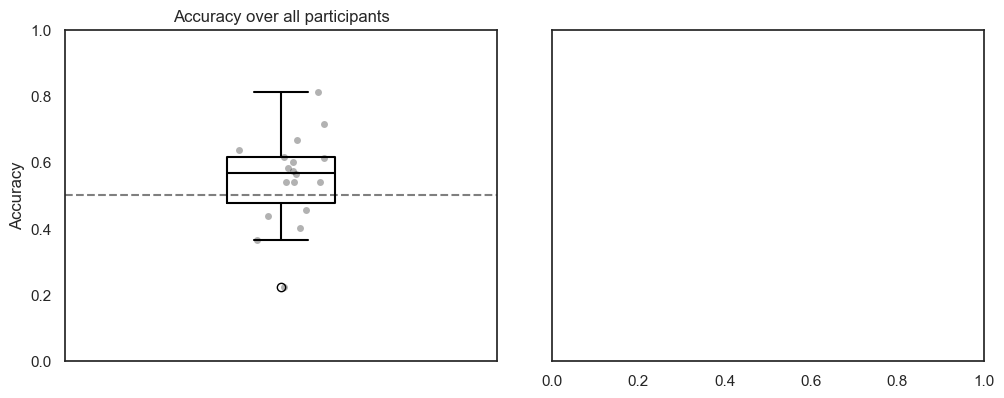

In [39]:
df_exp_1['category_new'] = df_exp_1.apply(lambda x: sdt_cat_new((x['CorrectResp'], x['Resp'])), axis=1)
df_exp_accuracy = df_exp_1.groupby('Subject').apply(lambda x: pd.Series({'accuracy': get_stats(x, 'accuracy')}), include_groups=False)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
plt.tight_layout(w_pad=2)
sns.boxplot(y='accuracy', data=df_exp_accuracy, width=0.25, color='k', fill=False, ax=axs[0])
sns.stripplot(y='accuracy', data=df_exp_accuracy, alpha=0.3, color='k', ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy')
axs[0].axhline(y=0.5, c='k', ls='--', alpha=0.5)
axs[0].set_title('Accuracy over all participants')

# To-do

- [x] Check if participants responded correctly
- [x] z-score responses for each participant
- [x] ttest for differences between blocks
- [ ] regression
- [x] non-parametric test instead of t-test
- [x] Compare with genuineness from Experiment 1 instead of this one
- [ ] Compute participant accuracy from Experiment 1 on the trials in Experiment 2

In [40]:
df['accuracy'] = df.apply(lambda x: 1 if x['category_new']=='hit' or x['category_new']=='cr' else 0, axis=1)
df['increase'] = df.apply(lambda x: 1 if x['delta_gen'] > 0 else 0, axis=1)
df_log = df[['subject', 'age', 'sex', 'trial', 'block', 'condition', 'category', 'category_new', 'genuineness', 'response', 'binary_resp', 'scaled_response', 'accuracy', 'increase']]
df_log = pd.get_dummies(df_log, columns=['block'], dtype='float')
df_log

,subject,age,sex,trial,condition,category,category_new,genuineness,response,binary_resp,scaled_response,accuracy,increase,block_eyes,block_mouth,block_nods,block_original
0,1,22.0,m,52_3.mov,true,hit,hit,0.750000,8.0,true,0.777778,1,1,1.0,0.0,0.0,0.0
1,1,22.0,m,58_1_2.mov,fake,fa,cr,0.600000,3.0,fake,0.222222,1,0,1.0,0.0,0.0,0.0
2,1,22.0,m,2_2_3.mov,fake,fa,fa,0.571429,7.0,true,0.666667,0,1,1.0,0.0,0.0,0.0
3,1,22.0,m,5_1.mov,true,hit,miss,1.000000,4.0,fake,0.333333,0,0,1.0,0.0,0.0,0.0
4,1,22.0,m,14_2.mov,true,miss,hit,0.400000,7.0,true,0.666667,1,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9,21.0,f,60_4_6.mov,fake,cr,cr,0.333333,3.0,fake,0.222222,1,0,0.0,0.0,0.0,1.0
3356,9,21.0,f,45_3.mov,true,miss,hit,0.125000,6.0,true,0.555556,1,1,0.0,0.0,0.0,1.0
3357,9,21.0,f,22_19_3_23_2.mov,fake,fa,fa,0.600000,10.0,true,1.000000,0,1,0.0,0.0,0.0,1.0
3358,9,21.0,f,56_2_3.mov,fake,fa,fa,0.750000,8.0,true,0.777778,0,1,0.0,0.0,0.0,1.0


In [41]:
for category in df_log['category'].unique():
    df_sub = df_log[df_log['category']==category]
    X = df_sub[['block_original', 'block_eyes', 'block_mouth', 'block_nods']]
    y = df_sub['increase']

    print(category)
    lom = pg.logistic_regression(X, y, penalty='l2')
    print(lom.round(2))

hit
            names  coef    se      z  pval  CI[2.5%]  CI[97.5%]
0       Intercept -1.40  0.07 -20.02  0.00     -1.54      -1.27
1  block_original  0.34  0.14   2.37  0.02      0.06       0.61
2      block_eyes  0.02  0.15   0.12  0.91     -0.28       0.31
3     block_mouth  0.02  0.15   0.12  0.91     -0.28       0.31
4      block_nods -0.37  0.17  -2.22  0.03     -0.70      -0.04
fa
            names  coef    se     z  pval  CI[2.5%]  CI[97.5%]
0       Intercept -0.12  0.06 -2.17  0.03     -0.23      -0.01
1  block_original  0.08  0.12  0.67  0.50     -0.16       0.32
2      block_eyes  0.23  0.12  1.91  0.06     -0.01       0.47
3     block_mouth -0.03  0.12 -0.26  0.79     -0.27       0.20
4      block_nods -0.28  0.12 -2.28  0.02     -0.52      -0.04
miss
            names  coef    se      z  pval  CI[2.5%]  CI[97.5%]
0       Intercept  0.72  0.06  12.18  0.00      0.60       0.83
1  block_original  0.24  0.13   1.80  0.07     -0.02       0.50
2      block_eyes -0.00  0.13  -0.